# **Homework 5 - ADM - Group #3**

## **Useful libraries**

In [1]:
import pandas as pd 
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from heapq import heapify, heappush, heappop
from IPython.display import Image
from IPython.core.display import HTML 
from tabulate import tabulate
import warnings
import itertools
warnings.filterwarnings("ignore")

## **1. Data**

Let's start by loading the three datasets that we are going to work with.

In [2]:
df_hero = pd.read_csv("hero-network.csv")

In [3]:
df_hero.head(5)

hero1                 hero2
0         LITTLE, ABNER        PRINCESS ZANDA
1         LITTLE, ABNER  BLACK PANTHER/T'CHAL
2  BLACK PANTHER/T'CHAL        PRINCESS ZANDA
3         LITTLE, ABNER        PRINCESS ZANDA
4         LITTLE, ABNER  BLACK PANTHER/T'CHAL

In [4]:
df_nodes = pd.read_csv("nodes.csv")

In [5]:
df_nodes.head(5)

node   type
0               2001 10  comic
1                2001 8  comic
2                2001 9  comic
3  24-HOUR MAN/EMMANUEL   hero
4  3-D MAN/CHARLES CHAN   hero

In [6]:
df_edges = pd.read_csv("edges.csv")

In [7]:
df_edges.head(5)

hero   comic
0  24-HOUR MAN/EMMANUEL  AA2 35
1  3-D MAN/CHARLES CHAN   AVF 4
2  3-D MAN/CHARLES CHAN   AVF 5
3  3-D MAN/CHARLES CHAN   COC 1
4  3-D MAN/CHARLES CHAN  H2 251

### Preprocessing

Now it's the time to adjust and clean our datasets.<br>
As we can see below some heroes' name contain white spaces or slashes at the end. 

In [8]:
df_hero.tail(5)

hero1              hero2
574462  COLOSSUS II/PETER RA           CALLISTO
574463              CALLISTO            ROGUE /
574464              CALLISTO           CALIBAN/
574465              CALIBAN/            ROGUE /
574466  HULK/DR. ROBERT BRUC  MARKS, DR. SHIELA

So we are going to delete the white spaces or slashes that can be present at the end of the names of the heroes.

In [9]:
df_hero["hero1"] = df_hero["hero1"].apply(lambda x: x.strip('/'))
df_hero["hero2"] = df_hero["hero2"].apply(lambda x: x.strip('/'))
df_hero["hero1"] = df_hero["hero1"].apply(lambda x: x.strip())
df_hero["hero2"] = df_hero["hero2"].apply(lambda x: x.strip())

In [10]:
df_edges["hero"] = df_edges["hero"].apply(lambda x: x.strip('/'))
df_edges["hero"] = df_edges["hero"].apply(lambda x: x.strip())

In [11]:
df_nodes["node"] = df_nodes["node"].apply(lambda x: x.strip('/'))
df_nodes["node"] = df_nodes["node"].apply(lambda x: x.strip())

In [12]:
df_hero.tail(5)

hero1              hero2
574462  COLOSSUS II/PETER RA           CALLISTO
574463              CALLISTO              ROGUE
574464              CALLISTO            CALIBAN
574465               CALIBAN              ROGUE
574466  HULK/DR. ROBERT BRUC  MARKS, DR. SHIELA

Now, we know that in the "hero-network.csv" dataset the names of the heroes are limited to 20 characters, so to have all datasets consistent, we cut all the heroes' names to 20 characters.

In [13]:
df_edges["hero"] = df_edges["hero"].apply(lambda x: x[:20])

In [14]:
df_edges.loc[75723]

hero     SPIDER-MAN/PETER PAR
comic                   A 118
Name: 75723, dtype: object

Finallly, we remove from the "hero-network.csv" the rows that have the same hero in the two columns, because this would form a self loop in the graph and we are not interested in those.

In [16]:
#remove self-loops
df_hero_noduplicate = df_hero[df_hero.hero1 != df_hero.hero2].copy(deep=True)

In [17]:
print('Number of selfloops:', df_hero.shape[0] - df_hero_noduplicate.shape[0])

Number of selfloops: 2232


In [18]:
#save the cleaned datasets in pickle format
df_edges.to_pickle("edges_clear.pkl")
df_hero_noduplicate.to_pickle("hero_clear.pkl")
df_nodes.to_pickle('nodes_clear.pkl')

In [2]:
#run if you need to load the cleaned datasets
df_hero_noduplicate = pd.read_pickle("hero_clear.pkl")
df_edges = pd.read_pickle("edges_clear.pkl")
df_nodes = pd.read_pickle("nodes_clear.pkl")

### Graphs setup

### *Graph 1*
The metric that we decided to use for the weighting of the graph is $\frac{1}{number of collaborations}$, in this way the more collaborations two heroes have, the less the cost. <br>
Now, to do so let's start by constructing a multigraph, that is a graph that can contain multiple edges between the same pair of nodes.

In [13]:
#initialize a Multigraph
Graph_1 = nx.MultiGraph()

#get all the heroes
list(set((df_hero_noduplicate.hero1).unique()).union(set((df_hero_noduplicate.hero2).unique())))

#add the heroes as nodes of the graph
Graph_1.add_nodes_from(list(set((df_hero_noduplicate.hero1).unique()).union(set((df_hero_noduplicate.hero2).unique()))))

#add the collaborations between the heroes as edges
Graph_1.add_edges_from(list(zip(list(df_hero_noduplicate.hero1),list(df_hero_noduplicate.hero2))))

nx.info(Graph_1)

'MultiGraph with 6421 nodes and 572235 edges'

Obtained the MultiGraph, we create the weighted Graph requested in this way: we iterate on all the edges of the multigraph, and for each couple we count the number of edges (assigning this number to the weight of the edge in the Graph). Then we simply invert the weights to obtain new weights that follow our metric.

In [14]:
# create weighted graph from Graph_1
Graph_1reduce = nx.Graph()
#iterate on all the edges of the multigraph
for u,v,w in Graph_1.edges:
    if Graph_1reduce.has_edge(u,v):
        Graph_1reduce[u][v]['weight'] += 1
    else:
        Graph_1reduce.add_edge(u, v, weight=1)
        
#invert the weights of the graph
for u,v in Graph_1reduce.edges:
    Graph_1reduce[u][v]['weight']=1/Graph_1reduce[u][v]['weight']

In [22]:
#example
Graph_1reduce.edges()[('PRINCESS ZANDA', 'LITTLE, ABNER')]['weight']

0.125

### *Graph 2*
In this case we simply have to create a graph with heroes and comics as nodes, there is and edge between a hero and a comic only if the hero has appered in that comic.

In [24]:
print("There are",(df_nodes[df_nodes.type=='comic'].node).shape[0], "nodes of type 'comic'")

There are 12651 nodes of type 'comic'


In [26]:
print("There are",(df_nodes[df_nodes.type=='hero'].node).shape[0], "nodes of type 'hero'")

There are 6439 nodes of type 'hero'


In [15]:
#initialize an undirected Graph
Graph_2 = nx.Graph()

#add heroes and comics as nodes
Graph_2.add_nodes_from(list((df_nodes.node).unique()))

#add an edge between a hero and a comic if the hero appears in that comic
Graph_2.add_edges_from(list(zip(list(df_edges.hero),list(df_edges.comic))))

nx.info(Graph_2)

'Graph with 19089 nodes and 96104 edges'

## **2. Backend Implementation**

As requested, to reduce computation time and improve network visualization, we wil consider the data for only top N heros. We define the top N heroes as the heroes who have appeared in the most number of comics.

In [16]:
def Top_N_heroes(N,df_edges):
    degree_nodes = df_edges.groupby('hero').size().reset_index()   #after this groupby each hero will be associated with the number of different comics in which appears 
    degree_nodes.rename(columns={0: "size"},inplace=True)          #rename the column created with 'size'
    first_N_heroes = list((degree_nodes.sort_values(by="size",ascending=False).head(N).hero))
    #last line will convert the PandasSerie into a list, containing the top N heroes sorted by the number of comics in which they appear
    return(first_N_heroes)

To simplify the code in the functionalities below we can also define some functions to build the subgraphs

In [17]:
def get_subgraph_1(graph_data, top_N_heroes):
    #take the subgraph with only the top N heroes as nodes
    graph = Graph_1reduce.subgraph(top_N_heroes)
    return graph


def get_subgraph_2(graph_data, top_N_heroes):
    #get the position of the comics in which at least one of the top N heroes is present
    pos = graph_data.hero.isin(top_N_heroes)
    #get the names of those comics
    top_comics = graph_data[pos].comic
    #take the subgraph
    graph = Graph_2.subgraph(list(top_N_heroes) + list(top_comics))
    return graph

### Functionality 1 - extract the graph's features
Input: 
* The graph data
* The graph type (ex., number 1 or number 2)
* N: denoting the top N heroes that their data should be considered

Output:
* The number of nodes in the network (if type 2, report for both node types)
* The number of collaborations of each superhero with the others (only if type 1)
* The number of heroes that have appeared in each comic (only if type 2)
* The network's density
* The network's degree distribution
* The average degree of the network
* The network's Hubs (hubs are nodes having degrees more extensive than the 95th percentile of the degree distribution)
* Whether the Network is sparse or dense

Depending on the graph that we are considering, we are interested in different features, so we implemented two different functions at support of the requested one.


In [30]:
def features_type_1(graph):
    '''
    Function that returns the features of interest for the graphs of type 1
    '''
    
    #get the number of nodes in the graph
    n_nodes = graph.number_of_nodes()
    
    #get the number of collaborations of each hero with the others
    collaborations = {}
    for hero in graph.nodes:
        collaborations[hero] = sum([1/graph[u][v]['weight'] for u,v in graph.edges(hero)])
        
    #get the density of the graph
    density = (2*len(graph.edges))/((n_nodes)*(n_nodes-1))
    
    #get the degrees of the nodes (useful for the degree distribution)
    degrees = [graph.degree(n) for n in graph.nodes()]
    
    #average degree
    average_degree = sum(degrees)/n_nodes
    
    #get hubs
    #1. get the 95th percentile
    p = np.percentile(np.array(degrees), 95)
    hubs = []
    for n in graph.nodes:
        if graph.degree(n) > p:
            hubs.append(n)        
            
    #dense / sparse network
    is_dense = density > 0.9
    
    return [n_nodes, collaborations, density, degrees, average_degree, hubs, is_dense]

In [31]:
def features_type_2(graph, top_N_heroes):
    '''
    Function that returns the features of interest for the graphs of type 2
    '''
    #comic nodes
    comics = set(graph.nodes).intersection(set(df_nodes[df_nodes.type=='comic'].node))
    #hero-nodes
    heroes = top_N_heroes
    
    #get number of comic nodes
    n_comics = len(comics)
    #get number of hero nodes
    n_heroes = len(heroes)
    
    #get the number of heroes per comic
    appearances = {}
    for comic in comics:
        count = 0
        for u,v in graph.edges(comic):
            if v in heroes:
                count += 1
        appearances[comic] = count
        
        
    #get the density of the graph
    density = (2*len(graph.edges))/((n_comics+n_heroes)*(n_comics+n_heroes-1))
    
    #get the degrees of the nodes (useful for the degree distribution)
    degrees = [graph.degree(n) for n in graph.nodes()]
    
    #average degree
    average_degree = sum(degrees)/(n_comics + n_heroes)
    
    #get hubs
    #1. get the 95th percentile
    p = np.percentile(np.array(degrees), 95)
    hubs = []
    for n in graph.nodes:
        if graph.degree(n) > p:
            hubs.append(n)
            
    #dense / sparse network
    is_dense = density > 0.9
    
    return [{'comics': n_comics, 'heroes': n_heroes}, appearances, density, degrees, average_degree, hubs, is_dense]

In [32]:
def graph_features(graph_data, type_graph, N):
    
    #get the heroes-nodes to consider
    top_N_heroes = Top_N_heroes(N, df_edges)
    
    if(type_graph==1):
        graph = get_subgraph_1(graph_data, top_N_heroes)
        return features_type_1(graph)
    else:
        graph = get_subgraph_2(graph_data, top_N_heroes)
        return features_type_2(graph, top_N_heroes)
    

### Functionality 2 -Find top superheroes!

Input:<br>
* The graph data
* A node (hero or comic)
* One of the given metrics : Betweeness, PageRank, ClosenessCentrality, DegreeCentrality
* N: denoting the top N heroes that their data should be considered

Output:<br>
* The metric's value over the considered graph
* The given node's value

In [31]:
def Find_top(graph , target_node , metric , N):
    
    top_N_heroes = Top_N_heroes(N,df_edges)
    
    if (target_node not in set(top_N_heroes)):
        print('The selected node is not among the Top N heroes')
        return 
    
    if (len(list(list(graph.edges(data=True))[0][-1])) == 1):
        subgraph_topN = get_subgraph_1(df_hero_noduplicate, top_N_heroes)
    else:
        subgraph_topN = get_subgraph_2(df_edges, top_N_heroes)

    if metric == 'Betweeness':
        centrality_ranking = nx.betweenness_centrality(subgraph_topN, weight = 'weight')
        return {'target_node':centrality_ranking[target_node], 'ranking':centrality_ranking}
        
    if metric == 'PageRank':
        centrality_ranking = nx.pagerank(subgraph_topN)
        return {'target_node':centrality_ranking[target_node], 'ranking':centrality_ranking}

    if metric == 'ClosenessCentrality':
        centrality_ranking = nx.closeness_centrality(subgraph_topN , distance='weight')
        return {'target_node':centrality_ranking[target_node], 'ranking':centrality_ranking}
        
    if metric == 'DegreeCentrality':
        centrality_ranking = nx.degree_centrality(subgraph_topN)
        return {'target_node':centrality_ranking[target_node], 'ranking':centrality_ranking}
    
    print('The selected metric is not supported')    
    return

* let's see how the four metrics considered to evaluate the centrality of graph nodes with `Find_top` are defined:

* The **betweenness centrality** of a node $v$ is given by the expression:<br><br>
$$
BC_{\text{score}}(v) = \sum_{s \neq v \neq t} \frac{|\{ \text{set of shorter path connecting $s$ and $t$ passing by $v$} \}|}{|\{ \text{set of shorter path connecting $s$ and $t$}  \}|}
$$

* The **closeness centrality** of a node $v$ is given by the expression:<br><br>
$$
CC_{\text{score}}(v) = \frac{N-1}{\sum_{u} d(v,u)}
$$
  where $N$ is the total number of nodes in the graph and $d(v,u)$ is the weighted distance between vertices $v$ and $u$.
  
* The **Degree centrality** of a node $v$ is given by its degree as the name suggests:<br><br>
$$
DC_{\text{score}}(v) = deg(v)
$$
  
  
  

* The **PageRank** score of a node $v$ is given by the expression:<br><br>
$$
PR_{\text{score}}(v) = \sum_{u} \frac{PR_{\text{score}}(u)}{\text{number of connections of $u$}}
$$
  PageRank  works by counting the number and 'quality' of connections to a node to determine a rough estimate of how important the node is. The underlying assumption is that more important node are likely to receive more links from other nodes, and so it results central in the graph structure.

### Functionality 3 - Shortest ordered Route
Input:

* The graph data
* A sequence of superheroes h = [h_2, ..., h_n-1]
* Initial node h_1 and an end node h_n
* N: denoting the top N heroes that their data should be considered

Output:
* The shortest walk of comics that you need to read to get from hero_1 to hero_n 

Considerations: For this functionality, you need to implement an algorithm that returns the shortest walk that goes from node h_j to h_n, which\
 visits in order the nodes in h. The choice of h_j and h_n can be made randomly (or if it improves the performance of the algorithm, you can also\
 define it in any other way)

Important Notes:

* This algorithm should be run only on the second graph.
* The algorithm needs to handle the case that the graph is not connected. Thus, only some of the nodes in h are reachable from h_1. In such \
a scenario, it is enough to let the program give in the output the string "There is no such path".
* Since we are dealing with walks, you can pass on the same node h_i more than once, but you have to preserve order. E.g., if you start from\
 Spiderman to reach deadpool, and your path requires you to visit iron-man and colossus, you can go back to any comics any time you \
 want, assuming that the order in which you visit the heroes is still the same.

In [33]:
#let's imprement the dijkstra algorithm to compute the shortest path between two nodes of a given graph G
def dijkstra(G, init, end):
    # Initialize distances and predecessors
    dist = {vertex: float('inf') for vertex in G}
    prev = {vertex: None for vertex in G}
    dist[init] = 0

    Queue = []
    for vertex in G:
        Queue.append((dist[vertex], vertex))
    heapify(Queue)

    # Loop until the priority queue is empty
    while Queue:
        # Extract the vertex with the smallest distance
        u = heappop(Queue)[1]

        # Update the distances of the neighbors
        for v,null in G[u].items():
            alt = dist[u] 
            if alt < dist[v]:
                dist[v] = alt
                prev[v] = u
                # Update the priority queue
                Queue = [(dist[vertex], vertex) for vertex in G]
                heapify(Queue)

    # Construct the shortest path
    path = []
    u = end
    while prev[u]:
        path.append(u)
        u = prev[u]
    path.append(init)
    return path[::-1]

In [19]:
def Shortest_Path_Comics(graph_data,seq_heroes,init_nodo,end_node,N):
    #initialize the list of the shortest path with the initial node
    Shortest_OR = [init_nodo]
    first_N_heroes = Top_N_heroes(N,graph_data)
    New_dataset = df_edges[df_edges['hero'].isin(first_N_heroes)]           #create the new dataset with only the topN heroes obtained
    Graph_3 = nx.Graph()                                                    #inizialize the graph
    #adding the edges from the new dataset created
    Graph_3.add_edges_from(list(zip(list(New_dataset.hero),list(New_dataset.comic))))
    #we will combine now the initial node, the sequence of superheroes and the final node
    seq_heroes=[init_nodo]+seq_heroes+[end_node]            
    #out algorithm will find the shortest path between two sequential heroes in the list and then combine all together
    #so we will obtain an unique path from h1 to hn passing through each node of the sequence, clearly in order.                
    for i in range(1,len(seq_heroes)):
        #we have to pay attention if the node is in the Graph
        if((Graph_3.has_node(seq_heroes[i-1])) & (Graph_3.has_node(seq_heroes[i]))):
            Shortest_OR += dijkstra(Graph_3,seq_heroes[i-1],seq_heroes[i])[1:]
        else:
            print("There is no such path.")
            break
    return(Shortest_OR,Graph_3)


### Functionality 4 - Disconnecting Graphs
Input: 
* The graph data
* heroA: a superhero to which will relate sub-graph G_a
* heroB: a superhero to which will relate sub-graph G_b
* N: denoting the top N heroes that their data should be considered

Output:
* The minimum number of links (by considering their weights) required to disconnect the original graph in two disconnected subgraphs: G_a and G_b.

The idea underneath this function is to iterate until there are paths that connect the two heroes and each time remove the edges with less weight in the path.

In [81]:
def disconnect_graph(graph_data, heroA, heroB, N):
    
    #get the heroes-nodes to consider
    top_N_heroes = Top_N_heroes(N, df_edges)
    
    if (heroA not in top_N_heroes) or (heroB not in top_N_heroes):
        raise ValueError("The two heroes are not present in the graph")
    
    original = get_subgraph_1(graph_data, top_N_heroes)
    modified = nx.Graph(original)
    
    count = 0  #variable that stores the sum of the weights
    #loop untike there are paths between heroA and heroB
    while nx.has_path(modified, heroA, heroB):
        #find the path
        path = dijkstra(modified, heroA, heroB)
        #take the edge with less weight
        weights = [modified[path[i]][path[i+1]]['weight'] for i,node in enumerate(path[:-1])]
        min_value = min(weights)
        min_idx = weights.index(min_value)
        modified.remove_edge(path[min_idx], path[min_idx+1])
        #update sum of the weights
        count += min_value
        
    return (count, original, modified)
    

### Functionality 5 - Extracting Communities
Input:

* The graph data
* N: denoting the top N heroes that their data should be considered
* Hero_1: denoting the name of one of the heroes
* Hero_2: denoting the name of one of the heroes

Output:

* The minimum number of edges that should be removed to form communities
* A list of communities, each containing a list of heroes that belong to them.
* If the Hero_1 and Hero_2 belongs to the same community

In [42]:
def edge_to_remove(graph):
  betw_cen = nx.edge_betweenness_centrality(graph)                          #compute edge_betweenness_centrality of all the edges the graph
  sort_bet = dict(sorted(betw_cen.items(), key=lambda item: -item[1]))      #sort the list and put it in a dictionary 
  first_edge = list(sort_bet.items())[:1]                                   #return the first element of the dict and put it in a list
  edge = first_edge[0][0]                                                   #this will give us only the edge we're interested in                                                
  return edge

In [40]:
def girvan_newman(graph):
	#find number of connected components
	cc = nx.connected_components(graph)
	#count how many connected components in the graph														
	cc_count = nx.number_connected_components(graph)

	#we need to remove the edges untill we have more than one component
	while(cc_count == 1):
		#remove_edge will remove edge from the graph, we will pass the output of the funcion defined earlier 'edge_to_remove'
		graph.remove_edge(edge_to_remove(graph)[0], edge_to_remove(graph)[1])
		cc = nx.connected_components(graph)						#find again the connected components
		cc_count = nx.number_connected_components(graph)		#count how many connected components in the new graph

	return(cc,graph)

In [38]:
nx.number_connected_components(Graph_1reduce)

4

Thanks to the fact there are at maximum 4 connected components we can use this info to consider at maximum 4 colours in the plot of the graph.

In [38]:
def functionality_5(graph_data,N,hero_1,hero_2):
    #we will obtain as usual the first N heroes we are interested in 
    top_N = Top_N_heroes(N,df_edges)
    #then create the subgraph 
    top_N_graph = get_subgraph_1(graph_data, top_N)
    conn_comp,grafo = girvan_newman(top_N_graph.copy())
    # find the nodes forming the communities
    node_groups = []
    
    #since conn_comp is not a list we will save each community obtained in a new list 'node_groups'
    for i in conn_comp:
      node_groups.append(list(i))
    
    # plot the communities
    #since the maximun of communities in the original is 4 we can consider at maximum 4 cases
    #assign each node a colour according to which community it belongs to
    color_map = []
    for node in top_N_graph:
        if node in node_groups[0]:
            color_map.append('blue')
        elif node in node_groups[1]:
            color_map.append('yellow')
        elif node in node_groups[2]:
            color_map.append('red')
        else: 
            color_map.append('green') 
    
    #print the number of edges to remove to obtain at least more than one community
    diff = top_N_graph.number_of_edges()-grafo.number_of_edges()
    print('The number of links that should be removed to have the communities:',diff)

    #print the table of the community as requested
    print('The list of community:\n')
    for elem in node_groups:
        name = []
        name.append(f'community {node_groups.index(elem)}')
        table = [name, elem]
        print(tabulate(table, headers='firstrow',tablefmt="mixed_grid"))

    #plot original graph
    plt.rcParams.update({'figure.figsize': (15, 10)})  
    plt.figure(1)
    plt.title('The original graph:')
    nx.draw(top_N_graph, with_labels=True)

    #plot the new graph obtained
    plt.figure(2)
    plt.title('The graph with community coloured differently:')
    nx.draw(top_N_graph, node_color=color_map, with_labels=True)
    plt.show()
    
    for elem in node_groups:
        if(hero_2 in elem):
            ind_hero_2 = node_groups.index(elem)            #return the community to which it belongs 'hero_2'
        if(hero_1 in elem):
            ind_hero_1 = node_groups.index(elem)            #return the community to which it belongs 'hero_2'
    if ind_hero_1==ind_hero_2:
        print(f"{hero_1} and {hero_2} belong to the same community, as we can see from the last plot.")
    else:
        print(f"{hero_1} and {hero_2} DOES NOT belong to the same community, as we can see from the last plot.")
    

We have also implemented a different method of community detection that find communities in G using greedy modularity maximization.

This function uses _Clauset-Newman-Moore_ greedy modularity maximization to find the community partition with the largest modularity.

Greedy modularity maximization begins with each node in its own community and repeatedly joins the pair of communities that lead to the largest modularity until no futher increase in modularity is possible (a maximum).

In [57]:
import networkx.algorithms.community as nxcom
def functionality_5_2(graph_data,N,hero_1,hero_2):
    top_N = Top_N_heroes(N,df_edges)
    top_N_graph = get_subgraph_1(graph_data, top_N)
    #the only difference with the previous cell is only in the way we obtain the community
    #we obtain now the community using the function greedy_modularity_communities
    communities = sorted(nxcom.greedy_modularity_communities(top_N_graph), key=len, reverse=True)
    node_groups = []

    for i in communities:
      node_groups.append(list(i))
    color_map = []
    for node in top_N_graph:
        if node in node_groups[0]:
            color_map.append('blue')
        elif node in node_groups[1]:
            color_map.append('yellow')
        elif node in node_groups[2]:
            color_map.append('red')
        else: 
            color_map.append('green')  

    print('The list of community:\n')
    for elem in node_groups:
        name = []
        name.append(f'community {node_groups.index(elem)}')
        table = [name, elem]
        print(tabulate(table, headers='firstrow',tablefmt="mixed_grid"))

    plt.rcParams.update({'figure.figsize': (15, 10)})  
    plt.figure(1)
    plt.title('The original graph:')
    nx.draw(top_N_graph, with_labels=True)

    plt.figure(2)
    plt.title('The graph with community coloured differently:')
    pos = nx.spring_layout(top_N_graph,seed=7)
    nx.draw(top_N_graph,pos=pos, node_color=color_map, with_labels=True)
    plt.show()
    
    for elem in node_groups:
        if(hero_2 in elem):
            ind_hero_2 = node_groups.index(elem)
        if(hero_1 in elem):
            ind_hero_1 = node_groups.index(elem)
    if ind_hero_1==ind_hero_2:
        print(f"{hero_1} and {hero_2} belong to the same community, as we can see from the last plot.")
    else:
        print(f"{hero_1} and {hero_2} DOES NOT belong to the same community, as we can see from the last plot.")

## **3. Frontend Implementation**

### Visualization 1 - Visualize some features of the network
* A table containing the following general information about the graph:
    * Number of nodes in the network
    * Density of the network
    * Average degree of the network
    * Whether the network is sparse or dense
    
* A table that lists the network's hubs

* A plot depicting the number of collaborations of each hero in descending order (if the graph is type 1)

* A plot depicting the number of heroes who appeared in each comic, sorted in descending order (if the graph is type 2)

* A plot depicting the degree distribution of the network

We are going to plot an example with both the graph types.<br>
Let's define a function that we can call to do the visualization.

In [40]:
from tabulate import tabulate

def visualize_features():
    #take the graph data desired
    graph_data_name = input("Enter the dataframe that you want to use:")

    #take the type of graph desired
    type_graph = int(input("Enter the type of graph that you want to build (1 or 2): "))

    #check if the input is consistent
    if graph_data_name == 'df_hero_noduplicate' and type_graph==1:
        graph_data = df_hero_noduplicate
    elif graph_data_name == 'df_edges' and type_graph==2:
        graph_data = df_edges
    else:
        raise ValueError("Input is not correct!")

    #take the N heroes more influent
    N = int(input("Enter the number of top heroes to consider: "))
    
    #get the features to plot
    res = graph_features(graph_data, type_graph, N)
    
    #PLOT
    if type_graph==1:
        title2 = 'Number of collaborations of each hero'
    else:
        title2 = 'Number of heroes who appeared in each comic'
    
    #print the table
    table = [['number of nodes', 'density', 'avg degree', 'is dense?'], [res[0], res[2], res[4], res[6]]]
    print(tabulate(table, headers='firstrow', tablefmt='fancy_grid'))
    
    #print the hubs
    print('Hubs:', res[5])
    
    #plot degree distrbution and appearences/collaborations
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8), tight_layout=True)
    #degree distribution
    if type_graph==2:
        ax1.set_xlim(0,30)
    ax1.hist(res[3], bins = max(res[3]))
    ax1.set_title('Degree distribution')
    #appearences/collaborations
    s = dict(sorted(res[1].items(), key=lambda item: item[1]))
    ax2.plot(s.keys(), s.values())
    ax2.set_title(title2)
    
    plt.show()

#### *Example of visualization with graph of type 1*

Enter the dataframe that you want to use: df_hero_noduplicate
Enter the type of graph that you want to build (1 or 2):  1
Enter the number of top heroes to consider:  50
╒═══════════════════╤═══════════╤══════════════╤═════════════╕
│   number of nodes │   density │   avg degree │ is dense?   │
╞═══════════════════╪═══════════╪══════════════╪═════════════╡
│                50 │  0.974694 │        47.76 │ True        │
╘═══════════════════╧═══════════╧══════════════╧═════════════╛
Hubs: []


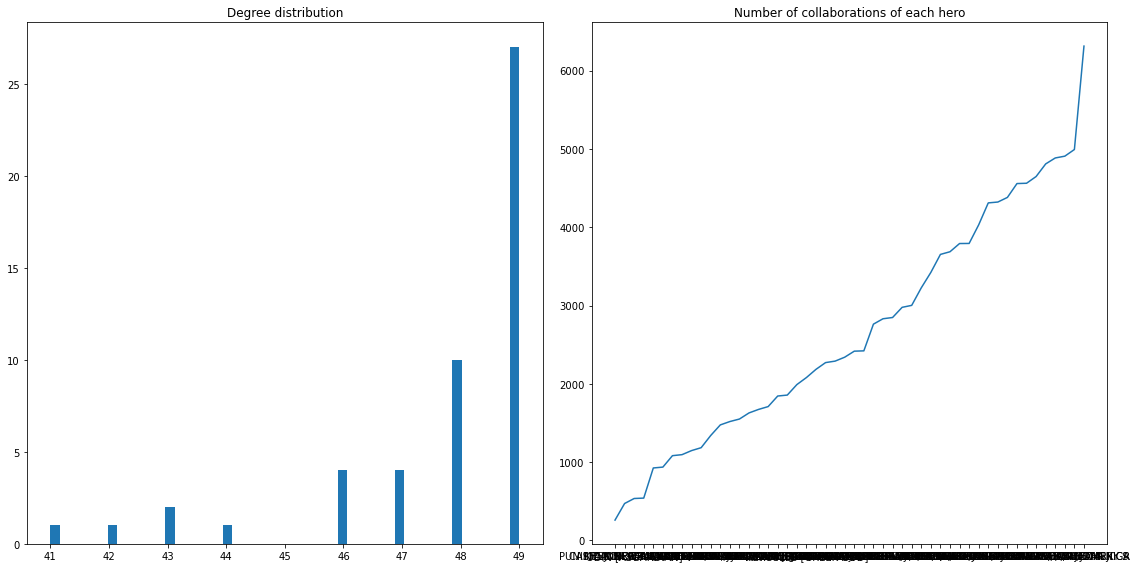

In [41]:
visualize_features()

#### *Example of visualization with graph of type 2*

Enter the dataframe that you want to use: df_edges
Enter the type of graph that you want to build (1 or 2):  2
Enter the number of top heroes to consider:  50
╒════════════════════════════════╤═════════════╤══════════════╤═════════════╕
│ number of nodes                │     density │   avg degree │ is dense?   │
╞════════════════════════════════╪═════════════╪══════════════╪═════════════╡
│ {'comics': 9236, 'heroes': 50} │ 0.000642863 │      5.96899 │ False       │
╘════════════════════════════════╧═════════════╧══════════════╧═════════════╛
Hubs: ['UX 138', 'FF 14', 'HULK/DR. ROBERT BRUC', 'PPSM2 4', 'A 201', 'IRON MAN/TONY STARK', 'A 157', 'H2 279', 'H2 321', 'A 7', 'A 242', 'UX 7', 'A 13', 'WASP/JANET VAN DYNE', 'FF3 23', 'A 18', 'DR. DOOM/VICTOR VON', 'A 221', 'A 333', 'UX 45', 'X 14', 'A 9', 'A3 2', 'H2 434', 'SENSM 28', 'XF 5', 'M/SHSW 9', 'CAPTAIN BRITAIN/BRIA', 'A 200', 'FF2 12', 'IW 6', 'A 170', 'A 332', 'M/SHSW 2', 'A 42', 'FF 28', 'W2 145', 'FFV.X 1', 'IW 1', 'PUNISHER II/F

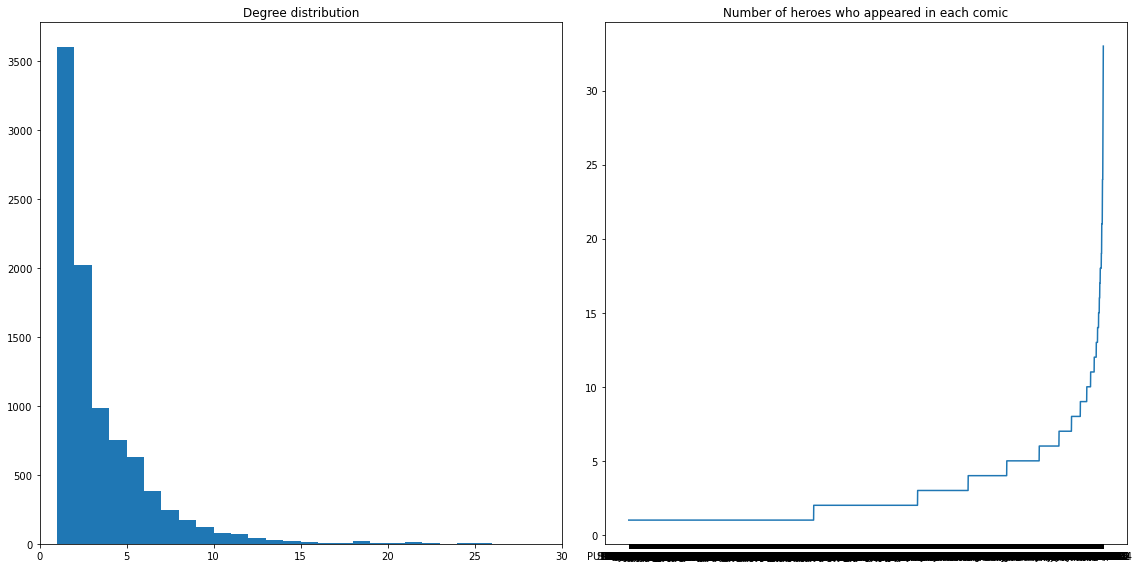

In [44]:
visualize_features()

<br>
<br>

***Comments***: The main information that we can retrieve from the two visualizations are the fact that the graph of type 1 is dense while the graph of type 2 is sparse, and also that the average degree is higher in the case of the graph 1. We can infer that in average each hero has collaborated with a lot of other heroes, while each comic is mainly about only one hero (we can see in the plot that almost 40% of all the comics contain only one hero)

### Visualization 2 - Visualize centrality measure

We anticipate seeing the Functionality 2 report in Visualization 2. To be more specific, we expect you to have the following report format:

* A table containing the information related to the requested centrality measure for:
    * The average of the requested centrality measure for all of the network's nodes
    * The requested centrality measure's value for the given node

In [48]:
metrics = ['Betweeness' , 'PageRank', 'ClosenessCentrality' , 'DegreeCentrality']

print('Target node:  \'SCARLET WITCH/WANDA\'')

for metric in metrics:
    result = Find_top(Graph_1reduce , 'SCARLET WITCH/WANDA' , metric , 50)

    #print the table
    table = [['average centrality measure', 'centrality measure\'s target node'], [np.mean(list(result['ranking'].values())), result['target_node']]]
    print('Metric used: '+metric)
    print(tabulate(table, headers='firstrow', tablefmt='fancy_grid'))

Target node:  'SCARLET WITCH/WANDA'
Metric used: Betweeness
╒══════════════════════════════╤════════════════════════════════════╕
│   average centrality measure │   centrality measure's target node │
╞══════════════════════════════╪════════════════════════════════════╡
│                    0.0305612 │                          0.0144558 │
╘══════════════════════════════╧════════════════════════════════════╛
Metric used: PageRank
╒══════════════════════════════╤════════════════════════════════════╕
│   average centrality measure │   centrality measure's target node │
╞══════════════════════════════╪════════════════════════════════════╡
│                         0.02 │                          0.0113015 │
╘══════════════════════════════╧════════════════════════════════════╛
Metric used: ClosenessCentrality
╒══════════════════════════════╤════════════════════════════════════╕
│   average centrality measure │   centrality measure's target node │
╞══════════════════════════════╪═════════════

### Visualization 3 - Visualize the shortest-ordered route
We anticipate seeing the Functionality 3 report in Visualization 3. To be more specific, we expect you to have the following report format:

* Print the comics in the shortest walk in order
* Plot the graph and identify the nodes and edges that appear in the shortest walk (please put an identifier on each edge in the shortest walk to determine the order that we should have the walk)

In [47]:
#define a function that takes all the input required to run the functionality3
#user have to be careful of the passed arguments since there is a sort of control
def input_visualization_3():
    graph_data = input("Enter the desidered graph:(In this case only '2' is allowed) ")
    if graph_data=='2':
        graph_data = df_edges
    else:
        raise ValueError("Re-run the cell, input not correct")
        sys.exit()
    N = int(input("Enter the top N heroes that we should considered: "))
    if(N<0 or N>Graph_2.number_of_nodes()):
        N=Graph_2.number_of_nodes()
    first_N_heroes = Top_N_heroes(N,graph_data)
    init_nodo = input("Enter the initial hero node: ")
    if(init_nodo not in first_N_heroes):
        raise ValueError("Re-run the cell, input not correct")
        sys.exit()
    end_nodo = input("Enter the hero end node: ")
    if(end_nodo not in first_N_heroes):
        raise ValueError("Re-run the cell, input not correct")
        sys.exit()
    seq_heroes = []
    n = int(input("Enter the list size \n"))
    for i in range(0, n):
        print("Enter hero at index", i, )
        hero= input()
        seq_heroes.append(hero)
    print("User list is ", [init_nodo]+seq_heroes+[end_nodo])
    for elem in seq_heroes:
        if elem not in first_N_heroes:
            raise ValueError("Re-run the cell, input not correct")
            sys.exit()
    return(graph_data,seq_heroes,init_nodo,end_nodo,N)

In [ ]:
#we will use this function only to generate the graph of the heroes and comics of the path
#also we will give at each node a 'peso' which indicate only the order of the edge in the path
#this function is useful to have a comprehensive visualization of the path
#since the graph is very dense is impossible to plot all the nodes with the related edges and hope to
#visualize the coloured path, so we choosed to represent only the heroes and the comics in the obtained path
def give_order_path(path):
    count = 0
    sub_hero = nx.Graph()
    for i in range(1,len(path)):
        count+=1
        if sub_hero.has_edge(path[i-1],path[i]):
            sub_hero[path[i-1]][path[i]]['peso'] += '-'+str(count)
        else:
            sub_hero.add_edge(path[i-1], path[i], peso=str(count))
    return(sub_hero)

In [ ]:
#setted all the parameters to make the plot
#we will pass to this function the graph obtained thanks to the function in the previous cell
def plot_graph(sub_hero):
    pos = nx.spring_layout(sub_hero,seed=7)  # positions for all nodes - seed for reproducibility
    plt.rcParams["figure.figsize"]=(10,5)
    # nodes
    nx.draw_networkx_nodes(sub_hero, pos,node_color='yellow', node_size=300)

    # edges
    nx.draw_networkx_edges(sub_hero, pos,width=4)
    nx.draw_networkx_edges(sub_hero, pos, width=4, alpha=0.5, edge_color="blue")

    # node labels
    nx.draw_networkx_labels(sub_hero, pos, font_size=10, font_family="sans-serif")
    # edge weight labels
    edge_labels = nx.get_edge_attributes(sub_hero, "peso")
    nx.draw_networkx_edge_labels(sub_hero, pos, edge_labels,font_color='red',font_size=15)

    ax = plt.gca()
    ax.margins(0.08)
    #plt.axis("off")
    plt.tight_layout()
    plt.show()

In [48]:
def visualization_3(graph_data,seq_heroes,init_nodo,end_nodo,N):
    first_N_heroes = Top_N_heroes(N,graph_data)
    Shortest_OR,Graph_3 = Shortest_Path_Comics(graph_data,seq_heroes,init_nodo,end_nodo,N)
    print(f'This is the connecting component we have found that start with {init_nodo} and ends at {end_nodo}:\n'
                ,Shortest_OR[1:-1])
    print("If we want to visualize only a walk of comics then: \n",[item for item in Shortest_OR if item not in first_N_heroes])
    sub_hero = give_order_path(Shortest_OR)
    plot_graph(sub_hero)
    return(sub_hero,Graph_3)

### Let's have a test

This is the connecting component we have found that start with SPIDER-MAN/PETER PAR and ends at THOR/DR. DONALD BLAK:
 ['A 11', 'CAPTAIN AMERICA', 'A 1', 'THING/BENJAMIN J. GR', 'A 1.5', 'SPIDER-MAN/PETER PAR', 'A 1.5']
If we want to visualize only a walk of comics then: 
 ['A 11', 'A 1', 'A 1.5', 'A 1.5']


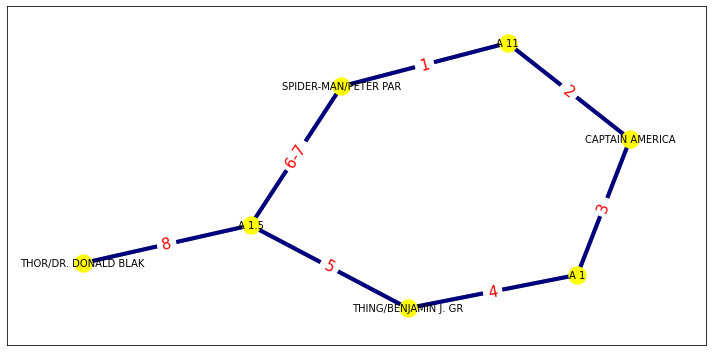

In [49]:
graph_data = df_edges
seq_heroes = ['CAPTAIN AMERICA', 'THING/BENJAMIN J. GR', 'SPIDER-MAN/PETER PAR']
init_nodo = 'SPIDER-MAN/PETER PAR'
end_nodo = 'THOR/DR. DONALD BLAK'
N = 5
sub_hero,Graph_3 = visualization_3(graph_data,seq_heroes,init_nodo,end_nodo,N)

Since even with only a few top heroes considered the graph is full of nodes, having a visualisation with all nodes is really not very indicative.\
We still used a graph visualisation programme called 'gephi'to get an idea of the situation anyway.\
Here we then passed the graph with the partition of the arcs to the programme.\
We gave value 1 to the arcs that were part of the shortest path, 0 otherwise.\
Gephi allowed us to visualise this graph full of nodes and we coloured the arcs belonging to the path.

In [50]:
Graph_3_sub = nx.Graph()
#iterate on all the edges of the multigraph
for u,v in Graph_3.edges:
    if sub_hero.has_edge(u,v):
        Graph_3_sub.add_edge(u, v, peso=1)
    else:
        Graph_3_sub.add_edge(u, v, peso=0)
nx.write_gexf(Graph_3_sub, "sub_hero.gexf")             #gephi use this format to read the graph

We can display all the edges in the graph.\
For a better visualisation, we used the 'Yifan Hiu' layout and chose that the size of the node name should be proportional to the number of links.

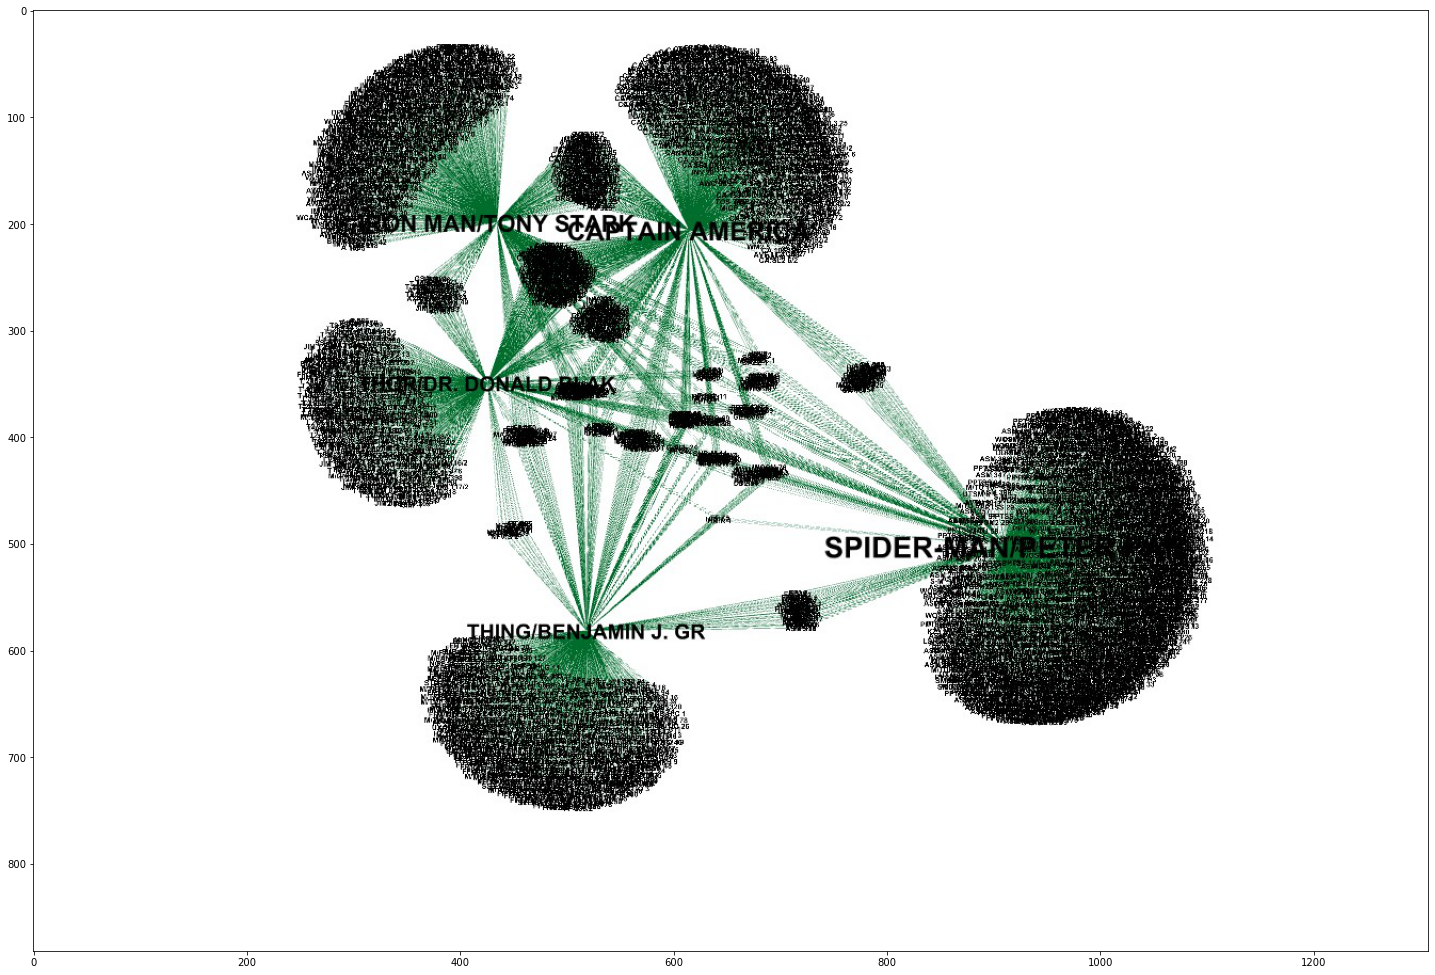

In [51]:
import matplotlib.image as mpimg
image = mpimg.imread("graphplot.jpg")
plt.rcParams["figure.figsize"]=(25,25)
plt.imshow(image)
plt.show()

In red we have the edges that belongs to the path considered before.\
Was impossible to print all the edges and the ones belonging to the shortest path with a different colour,\
 so we choose to display only the ones that belongs to the shortest path.

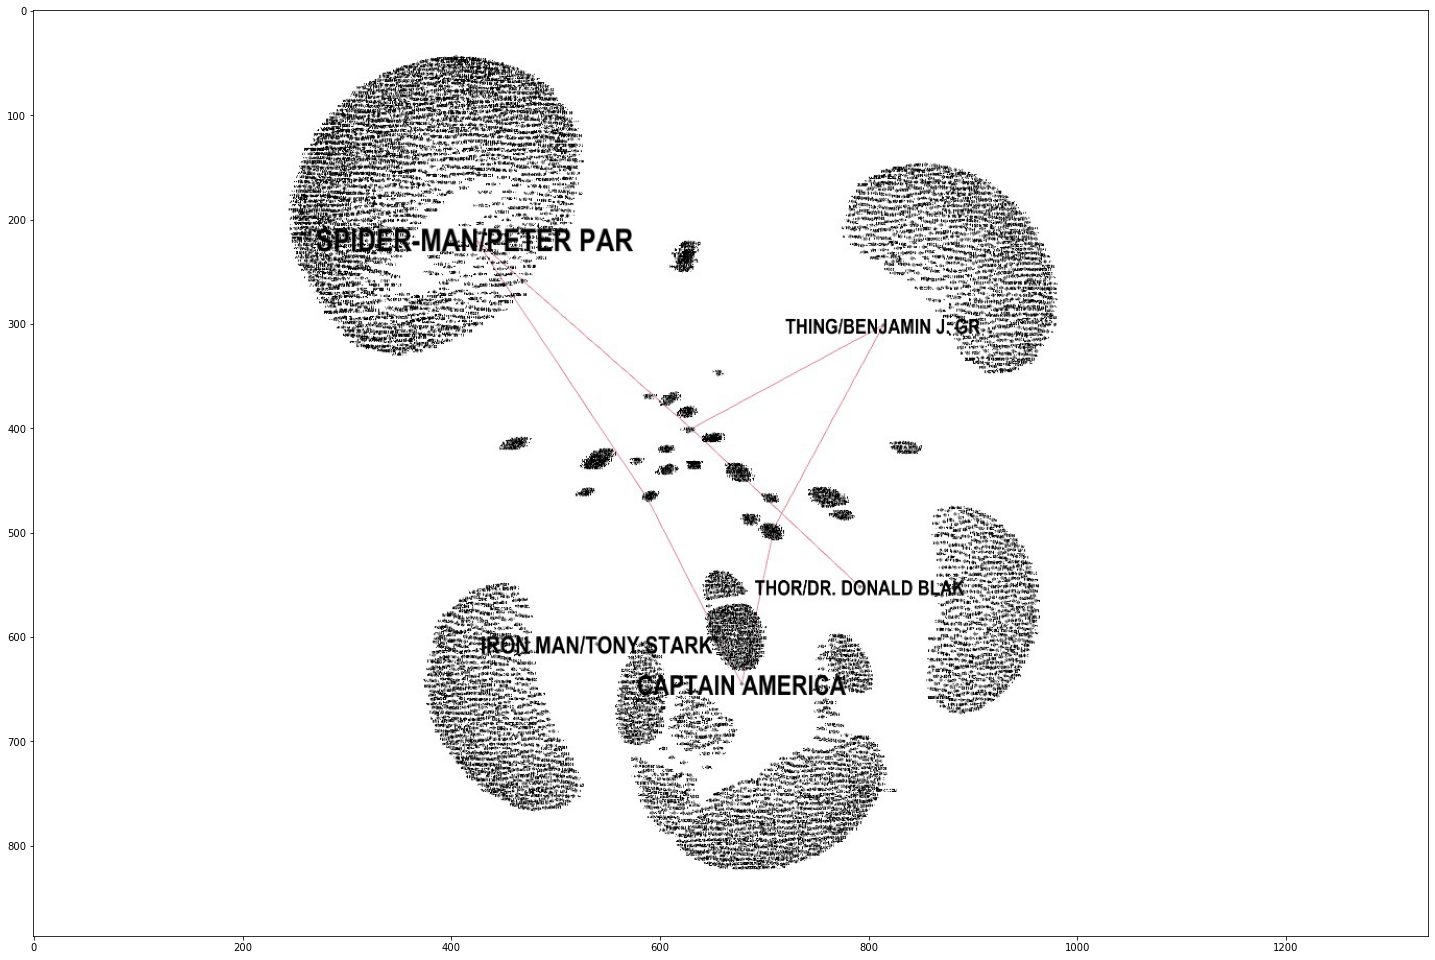

In [52]:
import matplotlib.image as mpimg
image = mpimg.imread("graphplot2.jpg")
plt.rcParams["figure.figsize"]=(25,25)
plt.imshow(image)
plt.show()

### Visualization 4 - Visualize the disconnected graph

* Print the number of the links that should be disconnected
* Plot the original graph
* Plot the graph after removing the links and identify the two nodes

To make the plot of the two graphs easier we ask to the *disconnect_graph()* function to return also the original and the modified graphs.

In [79]:
def visualize_disconnect():
    #get the inputs
    heroA = input('Enter the first hero:')
    heroB = input('Enter the second hero:')
    N = int(input("Enter the number of top heroes to consider: "))
    
    #call the function
    res = disconnect_graph(df_hero_noduplicate, heroA, heroB, N)
    
    #PLOT
    plt.rcParams["figure.figsize"] = [10, 10]
    color_map_original = ['red' if node == heroA or node == heroB else '#1E90FF' for node in res[1]]
    color_map_modified = ['red' if node == heroA or node == heroB else '#FF8C00' for node in res[2]]
    #print number of links to disconnect
    print('Number of links to disconnect (considering the weight):', res[0])
    #print original graph
    plt.figure(1)
    plt.title('The original graph:', pad=5, fontsize = 25)
    nx.draw(res[1], with_labels = True, node_size = 500, node_color = color_map_original, edge_color = '#00BFFF')
    #print modified graph
    plt.figure(2)
    plt.title('The modified graph:', pad=5, fontsize = 25)
    nx.draw(res[2], with_labels = True, node_size = 500, node_color = color_map_modified, edge_color = '#FFD700')

    plt.show()

Enter the first hero: IRON MAN/TONY STARK
Enter the second hero: CAPTAIN AMERICA
Enter the number of top heroes to consider:  8
Number of links to disconnect (considering the weight): 0.039043978036617945


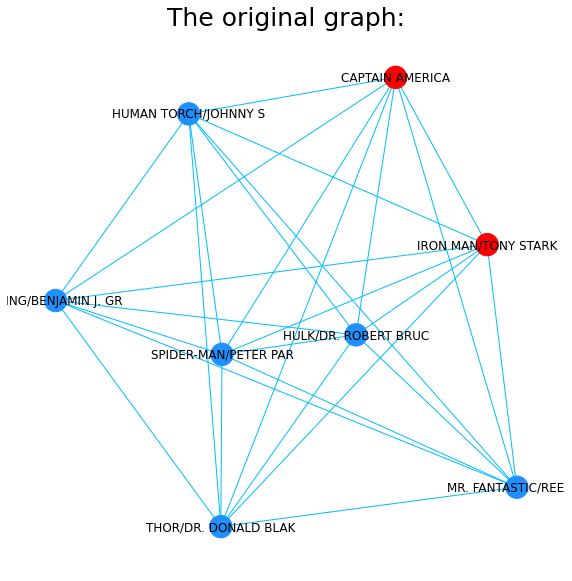

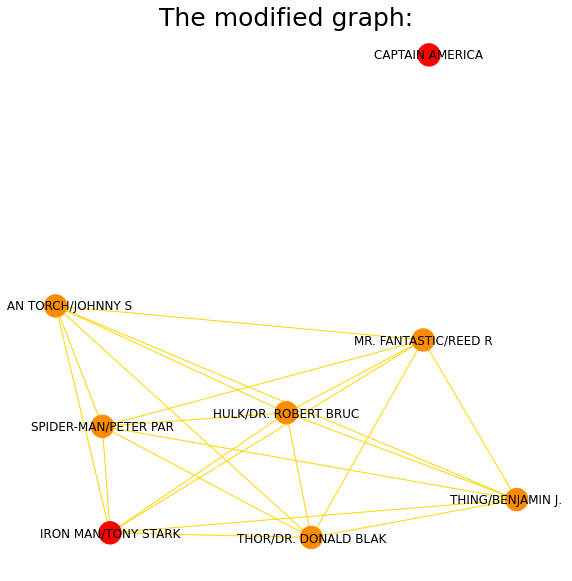

In [80]:
visualize_disconnect()

## Visualization 5 - Visualize the communities
We anticipate seeing the Functionality 5 report in Visualization 5. To be more specific, we expect you to have the following report format:

* Print the number of links that should be removed to have the communities
* A table depicting the communities and the heroes that belong to each community
* Plot the original graph
* Plot the graph showing the communities in the network
* Plot the final graph and identify the community/communities of Hero_1 and Hero_2

In [103]:
#define a function that takes all the input required to run the functionality5
#user have to be careful of the passed arguments since there is a sort of control
def input_visualization_5():
    graph_data = input("Enter the desidered graph:(In this case only '1' is allowed) ")
    if graph_data=='1':
        graph_data = df_hero_noduplicate
    else:
        raise ValueError("Re-run the cell, input not correct")
        sys.exit()
        
    N = int(input("Enter the top N heroes that we should considered: "))
    if(N<0 or N>Graph_1.number_of_nodes()):
        N=Graph_1.number_of_nodes()
    first_N_heroes = Top_N_heroes(N,df_edges)

    hero_1 = input("Enter the hero 1: ")
    if(hero_1 not in first_N_heroes):
        raise ValueError("Re-run the cell, input not correct")
        sys.exit()
    hero_2 = input("Enter the hero end node: ")
    if(hero_2 not in first_N_heroes):
        raise ValueError("Re-run the cell, input not correct")
        sys.exit()
    
    return(graph_data,N,hero_1,hero_2)

In [113]:
graph_data,N,hero_1,hero_2 = input_visualization_5()
functionality_5(graph_data,N,hero_1,hero_2)

* For the final output of your function, please set the Hero_1 to 'Captain America' and Hero_2 to 'Ironman' and show the results
* If Hero_1 and Hero_2 belong to the same community, identify that community; otherwise, identify those two communities that these heroes belong to.


The number of links that should be removed to have the communities: 19
The list of community:

┍━━━━━━━━━━━━━━━━━━━━━━┑
│ community 0          │
┝━━━━━━━━━━━━━━━━━━━━━━┥
│ CYCLOPS/SCOTT SUMMER │
┕━━━━━━━━━━━━━━━━━━━━━━┙
┍━━━━━━━━━━━━━━━━━┯━━━━━━━━━━━━━━━━━━━━━┯━━━━━━━━━━━━━━━━━━━━━━┯━━━━━━━━━━━━━━━━━━━━━━┯━━━━━━━━━━━━━━━━━━━━━━┯━━━━━━━━━━━━━━━━━━━━━━┯━━━━━━━━━━━━━━━━━━━━━┯━━━━━━━━━━━━━━━━━━━┯━━━━━━━━━━━━━━━━━━━━━━┯━━━━━━━━━━━━━━━━━━━━━┯━━━━━━━━━━━━━━━━━━━━━┯━━━━━━━━━━━━━━━━━━━━━┯━━━━━━━━━━━━━━━━━━━━━━┯━━━━━━━━┯━━━━━━━━━━━━━━━━━━━━━┯━━━━━━━━━━━━━━━━━━━━━━┯━━━━━━━━━━━━━━━━━┯━━━━━━┯━━━━━━━━━━━━━━━━━━━━━━┑
│                 │                     │                      │                      │                      │                      │                     │                   │                      │                     │                     │                     │                      │        │                     │                      │                 │      │ community 1          │


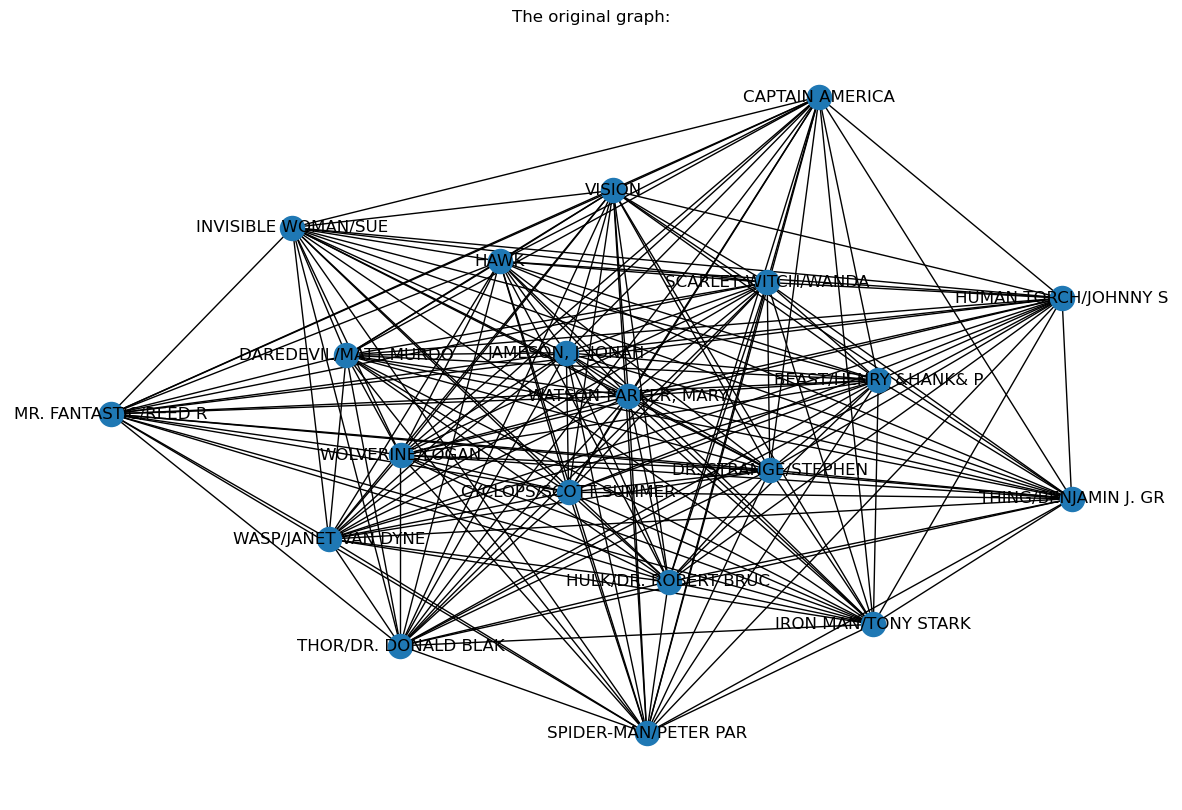

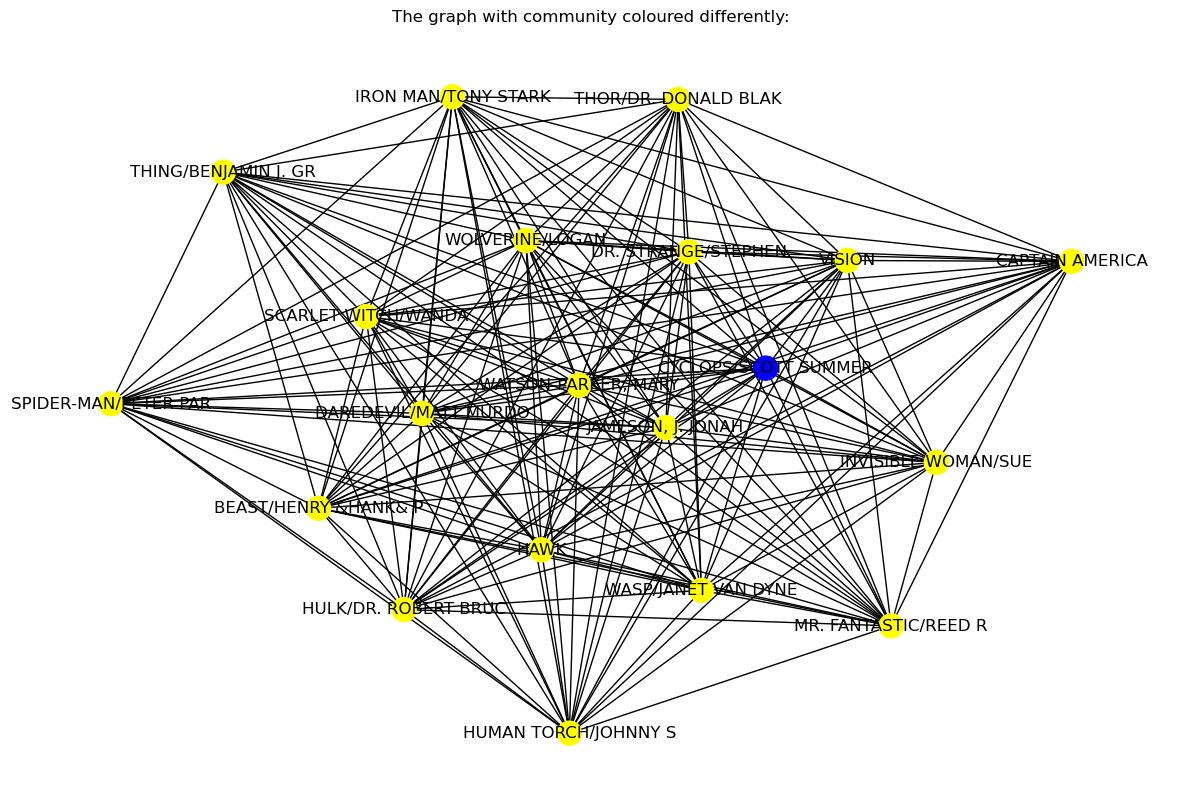

CAPTAIN AMERICA and IRON MAN/TONY STARK belong to the same community, as we can see from the last plot.


In [102]:
functionality_5(df_hero_noduplicate,20,'CAPTAIN AMERICA','IRON MAN/TONY STARK')

Give a look to the different method used:

The list of community:

┍━━━━━━━━━━━━━━━━━━━━━━┯━━━━━━━━━━━━━━━━━━━━━━┯━━━━━━━━━━━━━━━━━━━━━┯━━━━━━━━━━━━━━━━━━━━━┯━━━━━━━━━━━━━━━━━━━━━━┯━━━━━━━━━━━━━━━━━━━━━━┯━━━━━━━━┯━━━━━━━━━━━━━━┯━━━━━━━━━━━━━━━━━━━━━━┯━━━━━━━━━━━━━━━━━━━┯━━━━━━━━━━━┯━━━━━━━━━━━┯━━━━━━━━━━━━━━━━━━━━━━┯━━━━━━━━━━━━━━━━━━━━━━┯━━━━━━━━━━━━━━━━━━━━━━┯━━━━━━━━━━━━━━━━━━━━━━┯━━━━━━━━━━━━━━━━━━━┯━━━━━━━━━━━━━━━━━━━━━━┯━━━━━━━━━━━━━━━━━━━━━━┯━━━━━━┯━━━━━━━━━━━━━━━━━━━━━━┯━━━━━━━━━━━━━━━━━━━━━━┯━━━━━━━━━━━━━━━━━━━━━━┯━━━━━━━━━━━━━━━━━━┯━━━━━━━━━━━━━━━━━┯━━━━━━━━━━━━━━━━━━━━━━┯━━━━━━━━━━━━━━━━━━━━┯━━━━━━━━━━━━━━━━━━━━━┯━━━━━━━━━━━━━━━━━━━━━┯━━━━━━━━━━━━━━━━━━━━━━┯━━━━━━━━━━━━━━━━━┯━━━━━━━━━━━━━━━━━━━━━━┯━━━━━━━━━━━━━━━━━━━━━━┯━━━━━━┯━━━━━━━━━━━━━━━━━━━━┯━━━━━━━━━━━━━━━━━━┯━━━━━━━━━━━━━━━━━━━━━┯━━━━━━━━━━━━━━━━━━━━━━┯━━━━━━━━━━━━━━━━━━━━━┯━━━━━━━━━━━━━━━┯━━━━━━━━━━━━━━━━━━━━━━┯━━━━━━━━━━━━━━━━━━━━━━┯━━━━━━━━━━━━━━━━━━┯━━━━━━━━━━━━━━━━━━━━━┯━━━━━━━━━━━━━━━━━━━━━━┯━━━━━━━━━━━━━━━━━━━━━━┯━━━━━━━━━━━━━━━━━━━━━━┯━━━━━━━━━━━━━━━━

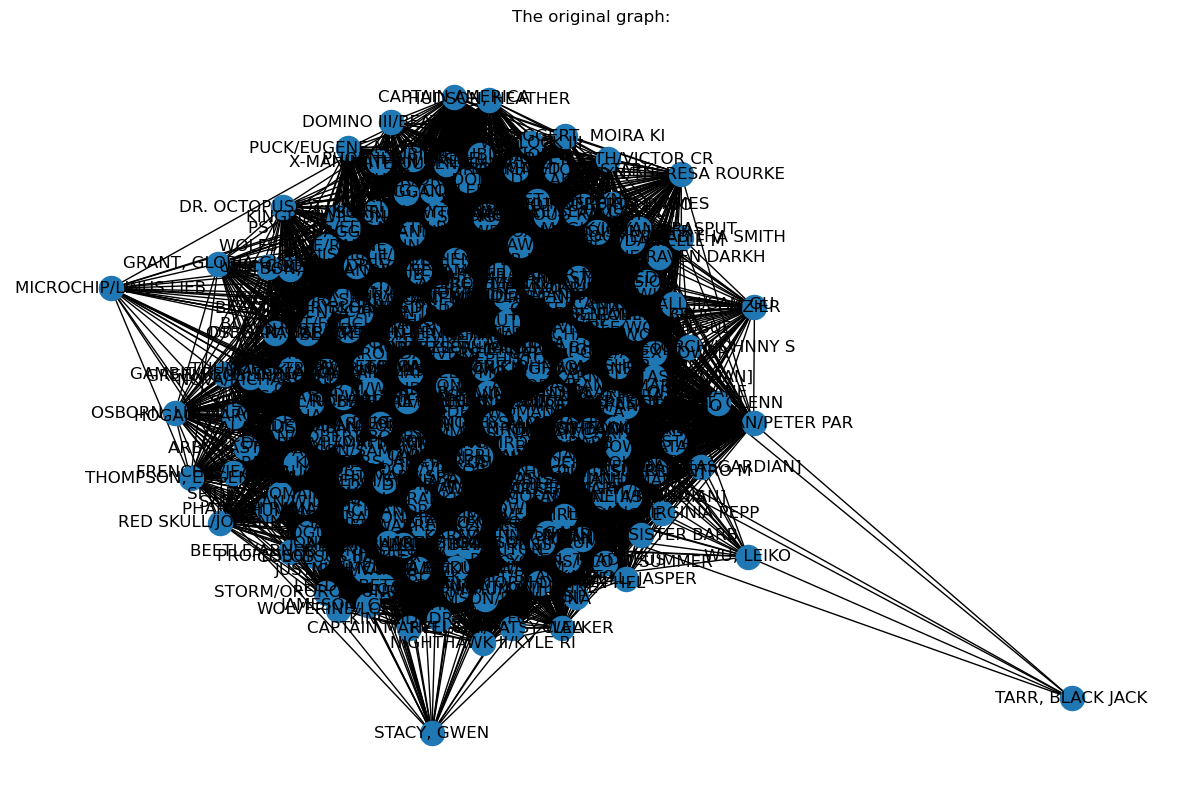

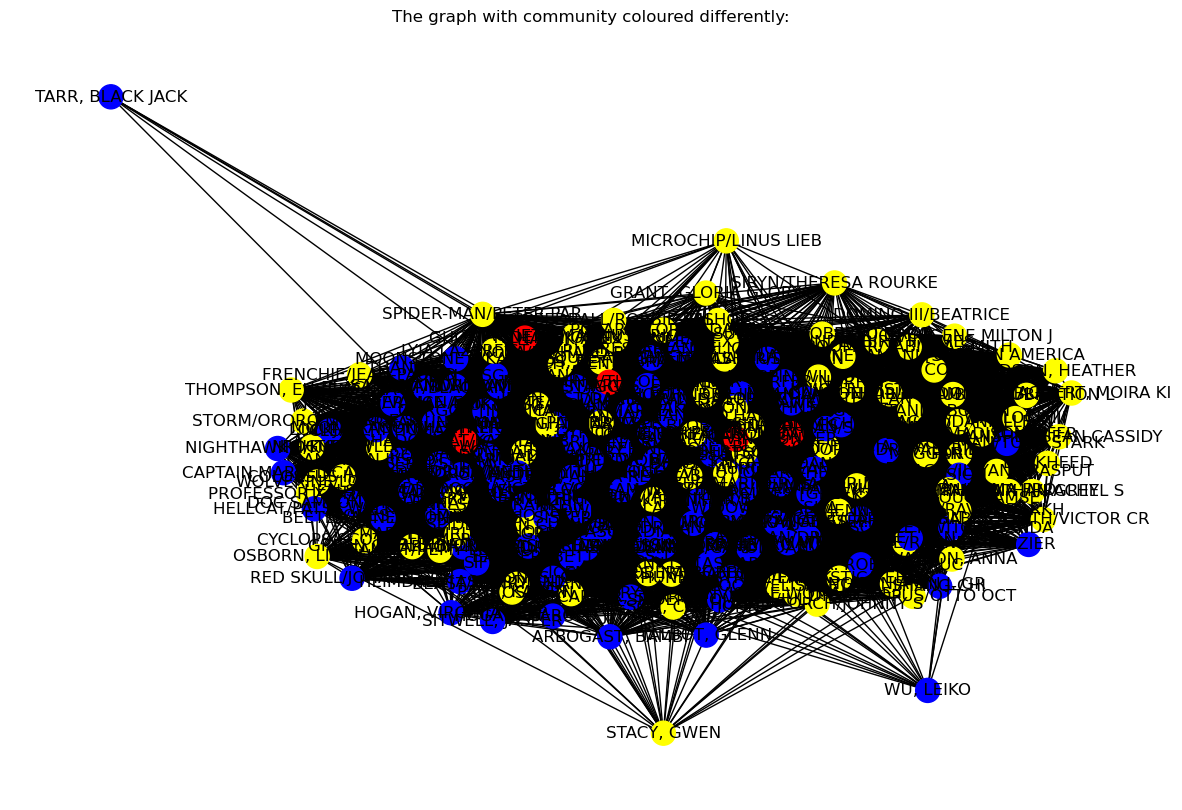

CAPTAIN AMERICA and IRON MAN/TONY STARK DOES NOT belong to the same community, as we can see from the last plot.


In [111]:
functionality_5_2(df_hero_noduplicate,200,'CAPTAIN AMERICA','IRON MAN/TONY STARK')

### 4. Command Line Question
In this question, you should use any command line tools that you know to answer the following questions\
 using the same datasets that you have been using so far:

* What is the most popular pair of heroes (often appearing together in the comics)?
* Number of comics per hero.
* The average number of heroes in comics.

Note: You may work on this question in any environment (AWS, your PC command line, Jupyter notebook, etc.), but the final script must be placed in CommandLine.sh, which must be executable.

Since in the original csv file('hero-network.csv') there are commas in the names we decided to do a little preprocesing to work better in the command line

In [ ]:
df_hero1 = pd.read_csv('hero_clear1.csv')
df_hero1['hero1'] = df_hero1['hero1'].apply(lambda x: x.replace(',',' '))
df_hero1['hero2'] = df_hero1['hero2'].apply(lambda x: x.replace(',',' '))
df_hero1_no_duplicate = df_hero1[df_hero1.hero1 != df_hero1.hero2].copy(deep=True)
df_hero1_no_duplicate.to_csv('hero_clear1.csv',index=False)

Same for the file 'edges.csv'.

In [ ]:
df_edges1 = df_edges
df_edges1['hero'] = df_edges1['hero'].apply(lambda x: x.replace(',',' '))
df_edges1.to_csv("edges_clear.csv",index=False)

We worked in the Linux Command Line with the new csv file 'hero_clear1.csv'.\
To confront our obtained result in the command line we perform the same operation here in pandas

#### 4.1 What is the most popular pair of heroes (often appearing together in the comics)?

In [ ]:
no_ordered_heroes = df_hero_noduplicate.apply(lambda x: x.hero1+' '+x.hero2 if x.hero1<x.hero2 else x.hero2+' '+x.hero1,axis=1)
no_ordered_heroes.value_counts().head(20)

MISS AMERICA/MADELIN PATRIOT/JEFF MACE       1894
HUMAN TORCH/JOHNNY S THING/BENJAMIN J. GR     744
HUMAN TORCH/JOHNNY S MR. FANTASTIC/REED R     713
MR. FANTASTIC/REED R THING/BENJAMIN J. GR     708
INVISIBLE WOMAN/SUE MR. FANTASTIC/REED R      701
HUMAN TORCH/JOHNNY S INVISIBLE WOMAN/SUE      694
INVISIBLE WOMAN/SUE THING/BENJAMIN J. GR      668
SPIDER-MAN/PETER PAR WATSON-PARKER, MARY      616
JAMESON, J. JONAH SPIDER-MAN/PETER PAR        526
CAPTAIN AMERICA IRON MAN/TONY STARK           446
SCARLET WITCH/WANDA VISION                    422
ANT-MAN/DR. HENRY J. WASP/JANET VAN DYNE      406
CYCLOPS/SCOTT SUMMER MARVEL GIRL/JEAN GRE     390
STORM/ORORO MUNROE S WOLVERINE/LOGAN          389
CAPTAIN AMERICA THOR/DR. DONALD BLAK          386
CAPTAIN AMERICA VISION                        385
CAPTAIN AMERICA WASP/JANET VAN DYNE           384
PARKER, MAY SPIDER-MAN/PETER PAR              380
CAPTAIN AMERICA SCARLET WITCH/WANDA           374
IRON MAN/TONY STARK SCARLET WITCH/WANDA       372


#### 4.2 Number of comics per hero.

In [ ]:
heroes_size = df_edges.groupby('hero').size().reset_index()
heroes_size.rename(columns={0: "size"},inplace=True)
heroes_size.sort_values(by="size",ascending=False).head(20)

hero  size
5299  SPIDER-MAN/PETER PAR  1577
857        CAPTAIN AMERICA  1334
2654   IRON MAN/TONY STARK  1150
5708  THING/BENJAMIN J. GR   963
5730  THOR/DR. DONALD BLAK   956
2547  HUMAN TORCH/JOHNNY S   886
3798  MR. FANTASTIC/REED R   854
2542  HULK/DR. ROBERT BRUC   835
6296       WOLVERINE/LOGAN   819
2636   INVISIBLE WOMAN/SUE   762
4889   SCARLET WITCH/WANDA   643
407   BEAST/HENRY &HANK& P   635
1594   DR. STRANGE/STEPHEN   631
6154   WATSON-PARKER  MARY   622
1340  DAREDEVIL/MATT MURDO   619
2388                  HAWK   605
6053                VISION   603
1286  CYCLOPS/SCOTT SUMMER   585
6136   WASP/JANET VAN DYNE   581
2704     JAMESON  J. JONAH   577

#### 4.3 The average number of heroes in comics.

In [ ]:
comic_size = df_edges.groupby('comic').size().reset_index()
comic_size.rename(columns={0: "size"},inplace=True)
comic_size_ord =comic_size.sort_values(by="size",ascending=False)
comic_size_ord

comic  size
2416              COC 1   111
5709               IW 3    91
5707               IW 1    90
4790             H2 279    87
5710               IW 4    80
...                 ...   ...
7569   MYSTIC COMICS 10     1
7591              N 2/4     1
7607               N 37     1
7609              N 4/2     1
12650       rse powers.     1

[12651 rows x 2 columns]

In [ ]:
np.mean(comic_size_ord)[0]

7.596553632123943

In the folder _'CommandLine_folder'_ in the repository you will find the bash file _'CommandLine.sh'_ \
and the txt file 'output_command' so that you can visualise that the results match. \
To have a better visualization this is the result so you can see the cells before. \
To see how we obtain this result see the Bash file in the folder _'CommandLine_folder'_ .

In [21]:
with open('output_command.txt') as f:
    lines = f.readlines()
new_lines = []
for line in lines:
    new_lines.append(line.replace("\n","").strip())
new_lines

["Let's display the 20 most popular pair of heroes:",
 '1894 MISSAMERICA/MADELIN-PATRIOT/JEFFMACE',
 '744 HUMANTORCH/JOHNNYS-THING/BENJAMINJ.GR',
 '713 HUMANTORCH/JOHNNYS-MR.FANTASTIC/REEDR',
 '708 MR.FANTASTIC/REEDR-THING/BENJAMINJ.GR',
 '701 INVISIBLEWOMAN/SUE-MR.FANTASTIC/REEDR',
 '694 HUMANTORCH/JOHNNYS-INVISIBLEWOMAN/SUE',
 '668 INVISIBLEWOMAN/SUE-THING/BENJAMINJ.GR',
 '616 SPIDER-MAN/PETERPAR-WATSON-PARKERMARY',
 '526 JAMESONJ.JONAH-SPIDER-MAN/PETERPAR',
 '446 CAPTAINAMERICA-IRONMAN/TONYSTARK',
 '422 SCARLETWITCH/WANDA-VISION',
 '406 ANT-MAN/DR.HENRYJ.-WASP/JANETVANDYNE',
 '390 CYCLOPS/SCOTTSUMMER-MARVELGIRL/JEANGRE',
 '389 STORM/OROROMUNROES-WOLVERINE/LOGAN',
 '386 CAPTAINAMERICA-THOR/DR.DONALDBLAK',
 '385 CAPTAINAMERICA-VISION',
 '384 CAPTAINAMERICA-WASP/JANETVANDYNE',
 '380 PARKERMAY-SPIDER-MAN/PETERPAR',
 '374 CAPTAINAMERICA-SCARLETWITCH/WANDA',
 '372 IRONMAN/TONYSTARK-SCARLETWITCH/WANDA',
 '',
 'Number of comics per hero (First 20):',
 '1577 : SPIDER-MAN/PETER PAR',
 '1334 :

## 5. **Bonus**

The bonus question was about the implementation of the PageRank algorithm with MapReduce paradigm. To do so we exploited AWS EMR using Hadoop and a notebook compiled with a PySpark kernel. The following cells are all written and run in the environment described above.

In [51]:
import numpy as np
import random as rn

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Let's define three useful functions:
- an initializer that stores the adjacency matrix as we want
- a mapper that performs the 'map' part in MapReduce
- and a function that does the PageRank

### *Version 1*

In [52]:
#this function return the adjacency matrix stored in another way and the vector q initialized as all 0s and a 1 in a random position.
#This is the initial position of the web surfer

def initialize(col):
        global accum
        accum += 1
        return (accum, [(elem, i) for i, elem in enumerate(col) if elem!=0])

def initializer(M):
    
    #store the adjacency matrix M in proper way
    #accum = -1
    a = [initialize(r) for r in M.T]
    
    #initialize vector q
    rn.seed(125433)
    n = len(M)
    initial_position = rn.randint(0, n-1)
    q = np.zeros(n)
    q[initial_position] = 1
    
    return sc.parallelize(a), q

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [53]:
def mapper(x, q):
    key = x[0]
    adj = [(key, n[0]*q[n[1]]) for n in x[1] if n[0]*q[n[1]]!=0]
    return adj

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [54]:
def pr_mr(M, beta, n_it):
    n = len(M)
    const = (1-beta)/n
    rdd, q = initializer(M)
    it = 0
    while(it<n_it):
        #mapper
        b = rdd.flatMap(lambda x: mapper(x,q))
        #reducer
        z = b.reduceByKey(lambda a,b: a+b)
        #update q
        q = np.zeros(n)
        for x in z.collect():
            q[x[0]] = x[1]
        q = beta*q + const
        it += 1
    return q

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

To check if the algorithm works we took from internet an example net of which we already know the solution. It's all summarized in this photo: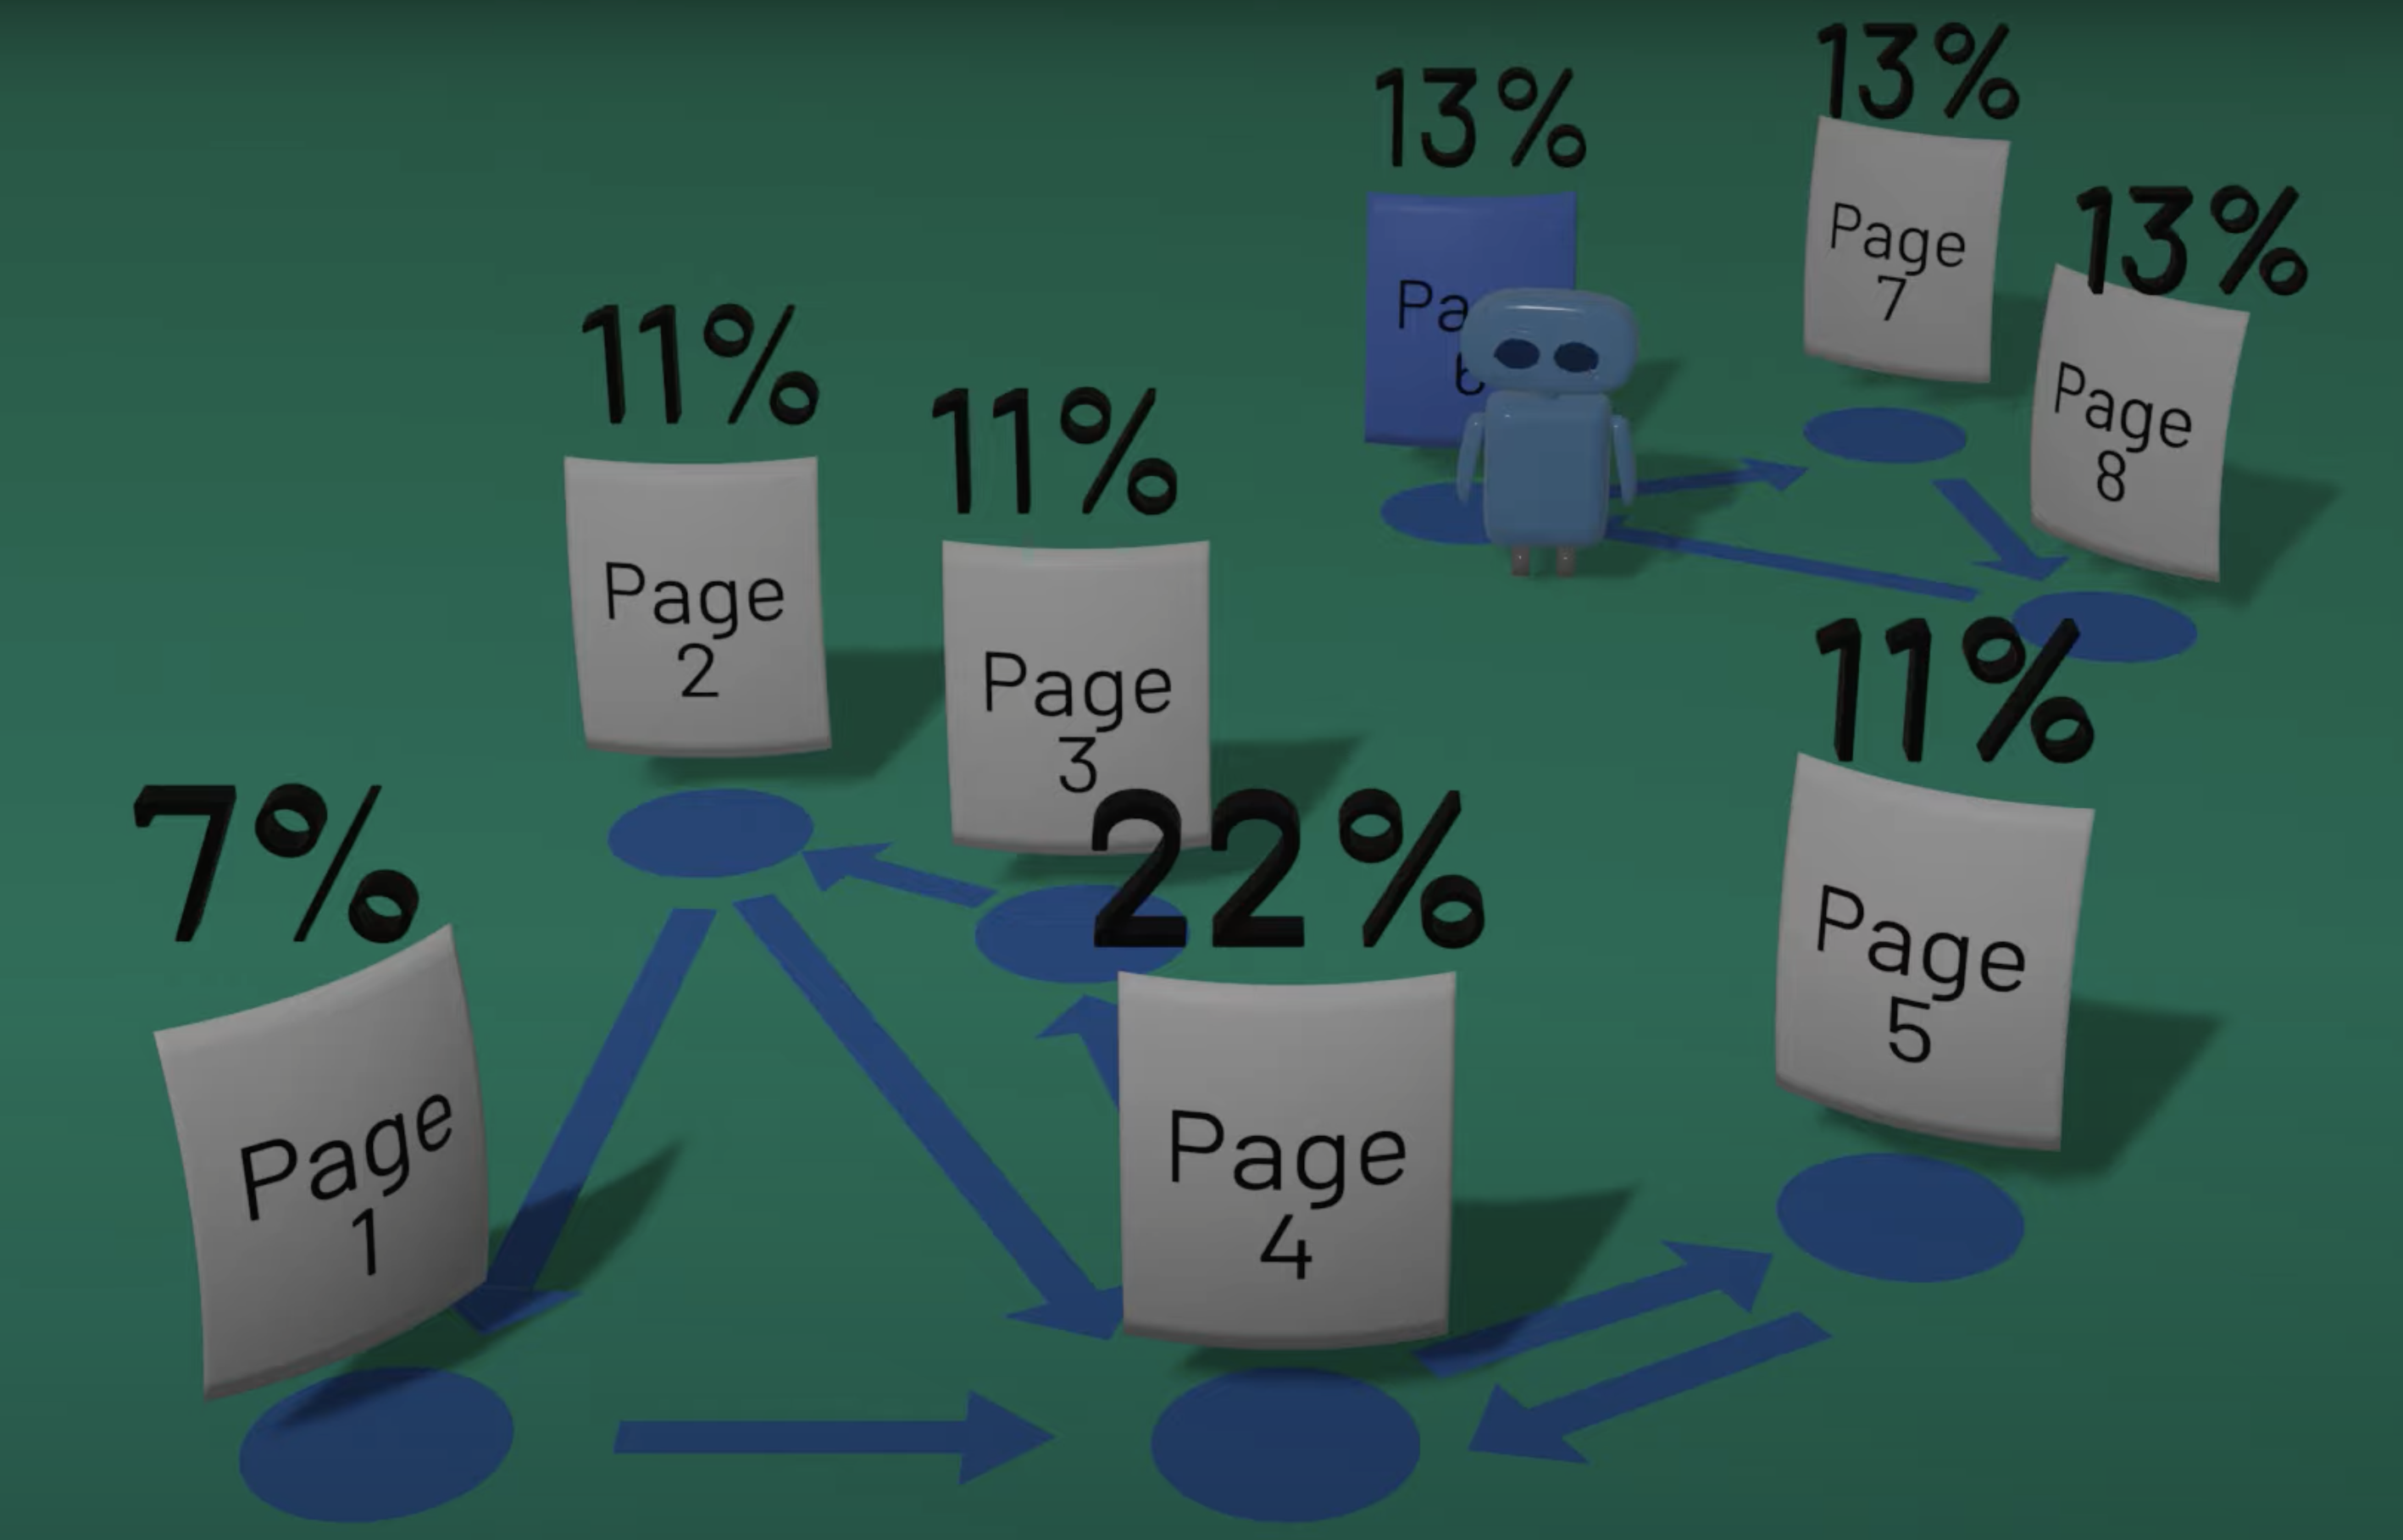

We copied the adjacency matrix:

In [55]:
M = np.array([[0, 0, 0, 1, 0, 0, 0, 0],
     [1/2, 0, 0, 1/2, 0, 0, 0, 0],
     [0, 1, 0, 0, 0, 0, 0, 0],
     [0, 0, 1/2, 0, 1/2, 0, 0, 0],
     [0, 0, 0, 1, 0, 0, 0, 0],
     [0, 0, 0, 0, 0, 0, 1, 0],
     [0, 0, 0, 0, 0, 0, 0, 1],
     [0, 0, 0, 0, 0, 1, 0, 0]])

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

An this is the result:

In [56]:
accum = -1
print(pr_mr(M, 0.85, 50))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

[0.06719178 0.11398658 0.11204897 0.21953885 0.11204897 0.12496303
 0.12525879 0.12496303]

It seems it worked.

Now let's run the algorithm also on the example on the pdf.

In [57]:
M2 = np.array([[0, 1/2, 0, 0],
     [1/3, 0, 1, 1/2],
     [1/3, 0, 0, 1/2],
     [1/3, 1/2, 0, 0]])

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [58]:
accum = -1
print(pr_mr(M2, 0.85, 50))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

[0.25 0.25 0.25 0.25]

### *Version 2*

In [59]:
def initializer2(M, k):
    
    #store the adjacency matrix M in proper way
    adj = []
    transp = M.T
    for i in range(0, len(M), k):
        for j in range(0, len(M), k):
            chunk = M[i:i+k, j:j+k]
            for z in range(0,k):
                l = [(elem, j+p) for p, elem in enumerate(chunk[z]) if elem!=0]
                if len(l) != 0:
                    adj.append((i+z,l))
            
    
    #initialize vector q
    rn.seed(125433)
    n = len(M)
    initial_position = rn.randint(0, n-1)
    q = np.zeros(n)
    q[initial_position] = 1
    
    return sc.parallelize(adj), q

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Let's have a look to the way the matrix is stored (it's the same of the example on the pdf, but with different indexes ):

In [60]:
k = 2
print(initializer2(M2, k)[0].collect())

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

[(0, [(0.5, 1)]), (1, [(0.3333333333333333, 0)]), (1, [(1.0, 2), (0.5, 3)]), (2, [(0.3333333333333333, 0)]), (3, [(0.3333333333333333, 0), (0.5, 1)]), (2, [(0.5, 3)])]

The mapper is very similar, only the indexes are switched because of the way the matrix is stored.

In [61]:
def mapper2(x, q):
    adj = [(n[1], n[0]*q[x[0]]) for n in x[1] if n[0]*q[x[0]]!=0]
    return adj

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [62]:
def pr_mr2(M, beta, n_it, k):
    n = len(M)
    const = (1-beta)/n
    rdd, q = initializer2(M, k)
    it = 0
    while(it<n_it):
        #mapper
        b = rdd.flatMap(lambda x: mapper2(x,q))
        #reducer
        z = b.reduceByKey(lambda a,b: a+b)
        #update q
        q = np.zeros(n)
        for x in z.collect():
            q[x[0]] = x[1]
        q = beta*q + const
        it += 1
    return q

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Let's run the algorithm on the example on the pdf. The result is the same of the version 1 algorithm, but it took half of the time.

In [63]:
print(pr_mr2(M2, 0.85, 50, 2))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

[0.25 0.25 0.25 0.25]

## 6. **ALGORITHMIC QUESTION**

## **Problem modeling**

* To solve the problem, we label the nodes of the $\quad 3 \times 3 \quad$ grid with the integers from $1$ to $9$ , as shown in the figure below.

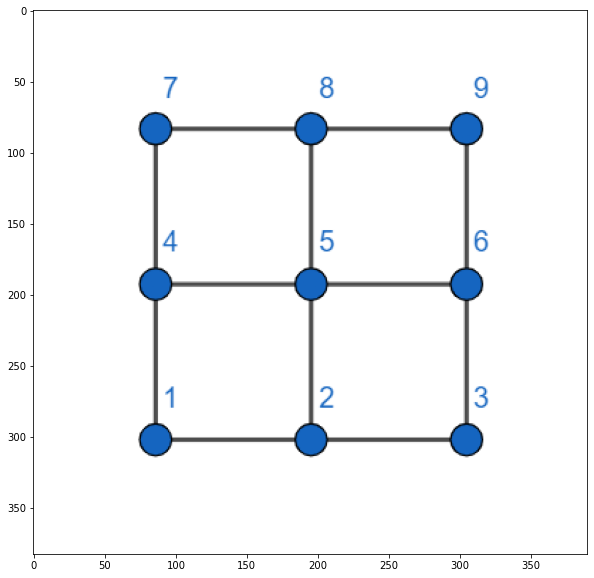

In [ ]:
import matplotlib.image as mpimg
image = mpimg.imread("grafo_password.png")
plt.rcParams["figure.figsize"]=(10,10)
plt.imshow(image)
plt.show()

* From the exercise description as input we have a string that read from left to right ,via individual letters, describes the direction ( **R**, **L**, **U**, and **D** ) of each line segment of a path through the grid, without giving any information about the length of these segments. <br> To better schematize the problem from now on the following notation will be considered :
   + `'r'`,`'l'`,`'u'`, and `'d'` correspond to a movement of a single segment to the Right, Left, Up, and Down directions;
   + `'R'`,`'L'`,`'U'`, and `'D'` correspond to a movement of two segment to the Right, Left, Up, and Down directions.

* Now in a dataframe we enter the information about the connections between the various nodes by indexing the rows with their labels and indicating the possible movements in the columns, taking into account the notation just fixed.

In [ ]:
nodes_connections= pd.DataFrame(index=[i for i in range(1,10)],columns=['r','R','l','L','u','U','d','D'])

nodes_connections.loc[1] = pd.Series([2,3,1,1,4,7,1,1],index=['r','R','l','L','u','U','d','D'])
nodes_connections.loc[2] = pd.Series([3,2,1,2,5,8,2,2],index=['r','R','l','L','u','U','d','D'])
nodes_connections.loc[3] = pd.Series([3,3,2,1,6,9,3,3],index=['r','R','l','L','u','U','d','D'])
nodes_connections.loc[4] = pd.Series([5,6,4,4,7,4,1,4],index=['r','R','l','L','u','U','d','D'])
nodes_connections.loc[5] = pd.Series([6,5,4,5,8,5,2,5],index=['r','R','l','L','u','U','d','D'])
nodes_connections.loc[6] = pd.Series([6,6,5,4,9,6,3,6],index=['r','R','l','L','u','U','d','D'])
nodes_connections.loc[7] = pd.Series([8,9,7,7,7,7,4,1],index=['r','R','l','L','u','U','d','D'])
nodes_connections.loc[8] = pd.Series([9,8,7,8,8,8,5,2],index=['r','R','l','L','u','U','d','D'])
nodes_connections.loc[9] = pd.Series([9,9,8,7,9,9,6,3],index=['r','R','l','L','u','U','d','D'])

nodes_connections

r  R  l  L  u  U  d  D
1  2  3  1  1  4  7  1  1
2  3  2  1  2  5  8  2  2
3  3  3  2  1  6  9  3  3
4  5  6  4  4  7  4  1  4
5  6  5  4  5  8  5  2  5
6  6  6  5  4  9  6  3  6
7  8  9  7  7  7  7  4  1
8  9  8  7  8  8  8  5  2
9  9  9  8  7  9  9  6  3

* For example, if we condider the entry relative to node $1$ and at column `'r'` we observe the value $2$ relative to the node of the same name, which in fact can be reached from node $1$ with a single movement to the right. <br> If from a node a particular move is not possible in the corresponding entry the label of the node in question is inserted, as noted for the entries of node $1$ corresponding to the columns `'l'`,`'L'`,`'d'` and `'D'`.

## **Solution**

* The below `Password` function represents an implementation to solve the problem, as input it requires the dataframe  related to the connections `nodes_connections` and the string that tracks the directions of the movements `input_movements` while as output it returns an integer corresponding to the number of possible patterns . Is structured as follows:<br><br>
    + before any calculation, if the length of `input_movements` is greater than 8=*(number of nodes -1)* the process stops and 0 is returned. In fact considering the conditions ,specified in the text of the exercise, that the poly-lines under consideration, constructed via `input_movements`, must satisfy they cannot consist of more than *(number of nodes -1)* segments;<br><br> 
    + all the possible paths that `input_movements` can represent are collected in the list `possible_path` as tuples.<br> For example if `input_movements` = 'DRU' we have: <br>
    `possible_path`= \[('d', 'r', 'u'), ('d', 'r', 'U'), ('d', 'R', 'u'), ('d', 'R', 'U'), ('D', 'r', 'u'), ('D', 'r', 'U'), ('D', 'R', 'u'), ('D', 'R', 'U' \];<br><br>
    + **ALGORITHM CORE** - considering the single path `path` among those found, in the $j$-$th$ entry of the list `nodes_visited` we keep updated the set of nodes that we meet using `path` assuming the $(j+1)$-$th$ node as starting point, once the path is finished if the length of this set coincides with the *(length of `path` +1)* we increase the counter of possible patterns by one, in fact for a pattern related to `path` to be consistent with the problem it must be such as to encounter *(length of `path` +1)* distinct nodes.


In [ ]:
def Password(nodes_connections,input_movements):
    
    # SUPPORT VARIABLES INITIALIZATION
    number_nodes = nodes_connections.shape[0] 
    lenght_path = len(input_movements)
    possible_decision = []    
    count_path = 0
    
    # CHECK ON THE CONSISTENCY OF 'input_movements'
    if lenght_path > (number_nodes-1):    
         return 0    
    
    # ALL POSSIBLE PATHS ARE FOUND
    for movement in input_movements:
         possible_decision.append((movement.lower(),movement))
    possible_path = list(itertools.product(*possible_decision))

    # WE CONTROL THE PATHS INIDVIDUALLY
    for path in possible_path:
        
        #ALGORITHM CORE APPLIED TO ALL NODES SIMULTANEOUSLY
        nodes_visited = [ set([i]) for i in range(1,number_nodes+1) ]
        current_positions  = [ i for i in range(1,number_nodes+1) ]

        for movement in path:
            
            for j in range(number_nodes):
                
                movement_node_j = nodes_connections.loc[current_positions[j], movement]
                current_positions[j] = movement_node_j
                nodes_visited[j].add(movement_node_j)
            
            count_path += [ len(p) for p in nodes_visited ].count(lenght_path+1)            

    return count_path    

## **Testing**

* Let us now test the algorithm with the three example inputs given in the exercise trace:

In [ ]:
input_1 = 'DRU'
input_2 = 'R'
input_3 = 'LDRDRUL'

In [ ]:
print('The possible pattern encoded by the direction string \''+input_1+'\' are: '+str(Password(nodes_connections,input_1)))
print('The possible pattern encoded by the direction string \''+input_2+'\' are: '+str(Password(nodes_connections,input_2)))
print('The possible pattern encoded by the direction string \''+input_3+'\' are: '+str(Password(nodes_connections,input_3)))

The possible pattern encoded by the direction string 'DRU' are: 15
The possible pattern encoded by the direction string 'R' are: 9
The possible pattern encoded by the direction string 'LDRDRUL' are: 0
